## Summary: 
### The goal of this study is provide a target list to Telephonic Marketing Team in which the customer in the list should have higher chance to subscribe a Term Deposit.
## In this study:
### Firstly, I do Exploratory Data Analysis with Visualization based on 3 Areas: Demographic, Banking Service and Contact History to find out Target Customer and Suggest Resource Allocation.
### Secondly, I do Data Cleaning to fill Missing Value
### Thirdly, I do Feature Engineering to rescale numeric data and form new features based on existing features.
### Then, I train 5 models (Logistic Regression, Support Vector Classifer, KNN, Random Forest and XGB) and do Model Evaluation to choose the best ones to apply in another test data set. 

# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', None)

# EDA (Exploratory Data Analysis)

In [2]:
df=pd.read_csv('train.csv',delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Detailed Column Descriptions:
#### 1 - age (numeric)
#### 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
#### 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
#### 4 - education (categorical: "unknown","secondary","primary","tertiary")
#### 5 - default: has credit in default? (binary: "yes","no")
#### 6 - balance: average yearly balance, in euros (numeric)
#### 7 - housing: has housing loan? (binary: "yes","no")
#### 8 - loan: has personal loan? (binary: "yes","no")
### Related with the last contact of the current campaign:
#### 9 - contact: contact communication type (categorical: "unknown","telephone","cellular")
#### 10 - day: last contact day of the month (numeric)
#### 11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
#### 12 - duration: last contact duration, in seconds (numeric)
### Other attributes:
#### 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
#### 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
#### 15 - previous: number of contacts performed before this campaign and for this client (numeric)
#### 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
### Output variable (desired target):
#### 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [4]:
df.shape

(45211, 17)

#### We have 45211 observations and 16 attributes and 1 label in our dataset.

In [5]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [6]:
df.y.value_counts()[1]/(df.y.value_counts()[0]+df.y.value_counts()[1])

0.11698480458295547

#### We can see that the label 'y' (Client Subscribed a Term Deposit) is imbalance, so, we need imbalance handling before model training.

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [157]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### There is no missing value. However, we can see that there are some columns with value 'unknown' before.

In [7]:
df=pd.read_csv('train.csv',delimiter=';',na_values='unknown')

In [8]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

#### There are 4 columns with missing value, we need to deal with them before model training.

In [9]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### Here we can see that :
### 1. Age of mean and median are similar, so, Age is normally distributed.
### 2. Balance and Duration with mean >> median, so, Balance and Duration are right skewed.
### 3. Day, Campaign, PDays and Previous are more likely discrete value rather than numeric value.

## Demographic

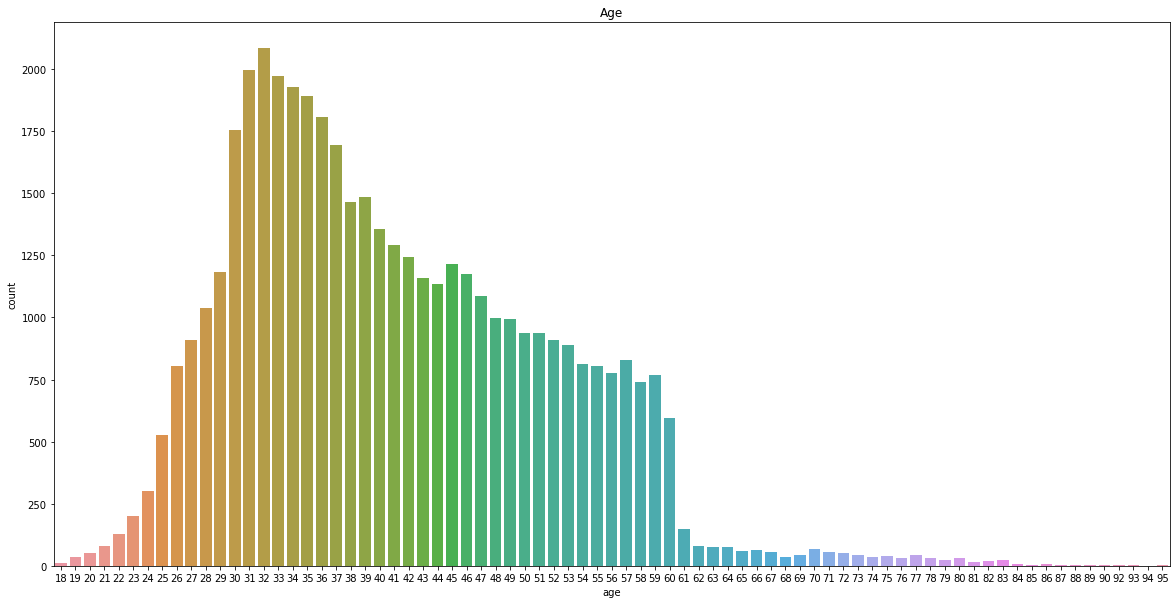

In [10]:
plt.figure(figsize=(20,10))
plt.title('Age')
sns.countplot(df['age'])

#### Most of our customers are around 30-37, only less customers are below 25 or above 60. 

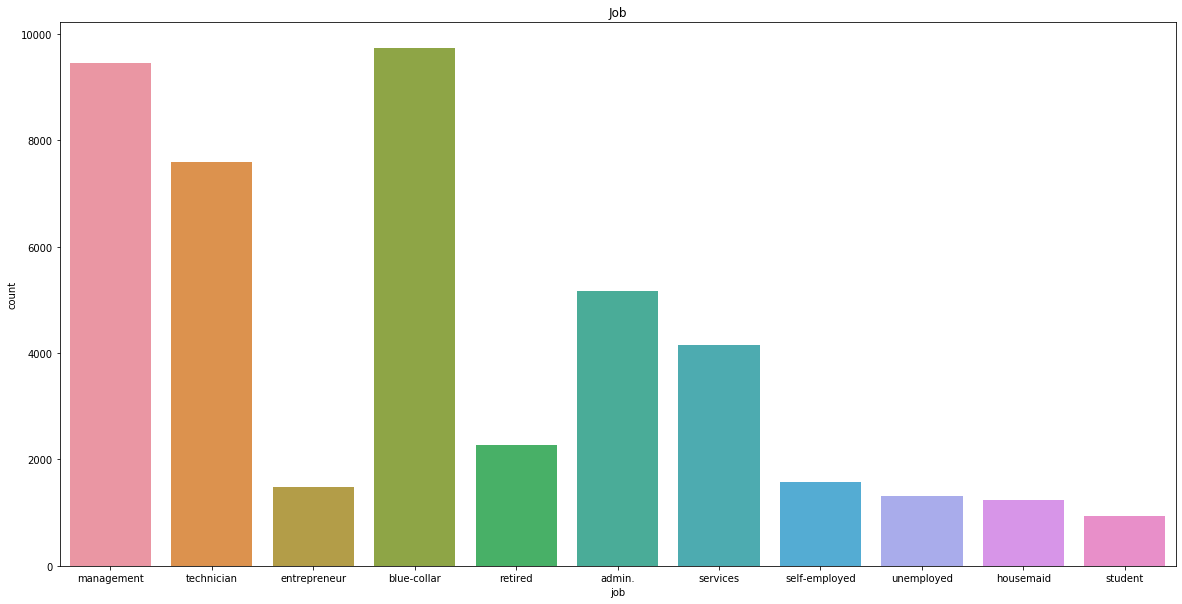

In [13]:
plt.figure(figsize=(20,10))
plt.title('Job')
sns.countplot(df['job'])

In [49]:
job_sub1=df.groupby(['y','job']).agg({'y':'count'})
job_sub1.columns=['ct']
job_sub1=job_sub1.reset_index()
job_sub2=job_sub1.pivot(index='job',columns='y',values='ct')
job_sub2=job_sub2.reset_index()
job_sub2['No']=job_sub2['no']/(job_sub2['no']+job_sub2['yes'])
job_sub2['Yes']=1-job_sub2['No']
job_sub2=job_sub2.drop(['no','yes'],axis=1)

In [50]:
job_sub2

y,job,No,Yes
0,admin.,0.877973,0.122027
1,blue-collar,0.927250,0.072750
2,entrepreneur,0.917283,0.082717
3,housemaid,0.912097,0.087903
4,management,0.862444,0.137556
5,retired,0.772085,0.227915
6,self-employed,0.881571,0.118429
7,services,0.911170,0.088830
8,student,0.713220,0.286780
9,technician,0.889430,0.110570


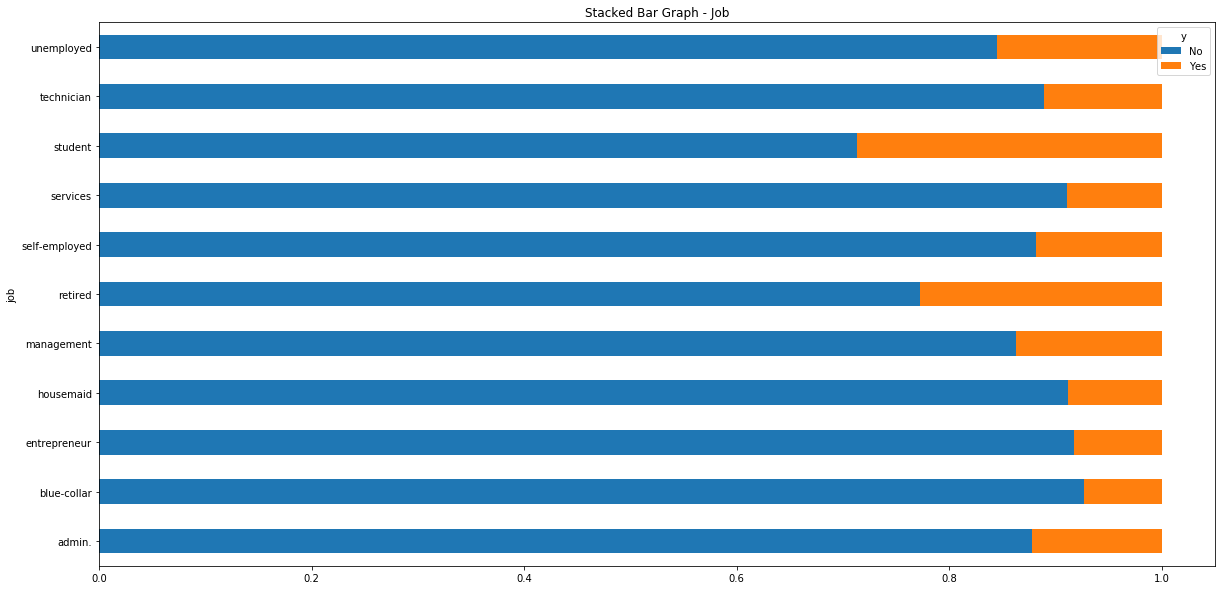

In [63]:
job_sub2.plot( 
    figsize=(20,10),
    x = 'job', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph - Job', 
    mark_right = True)

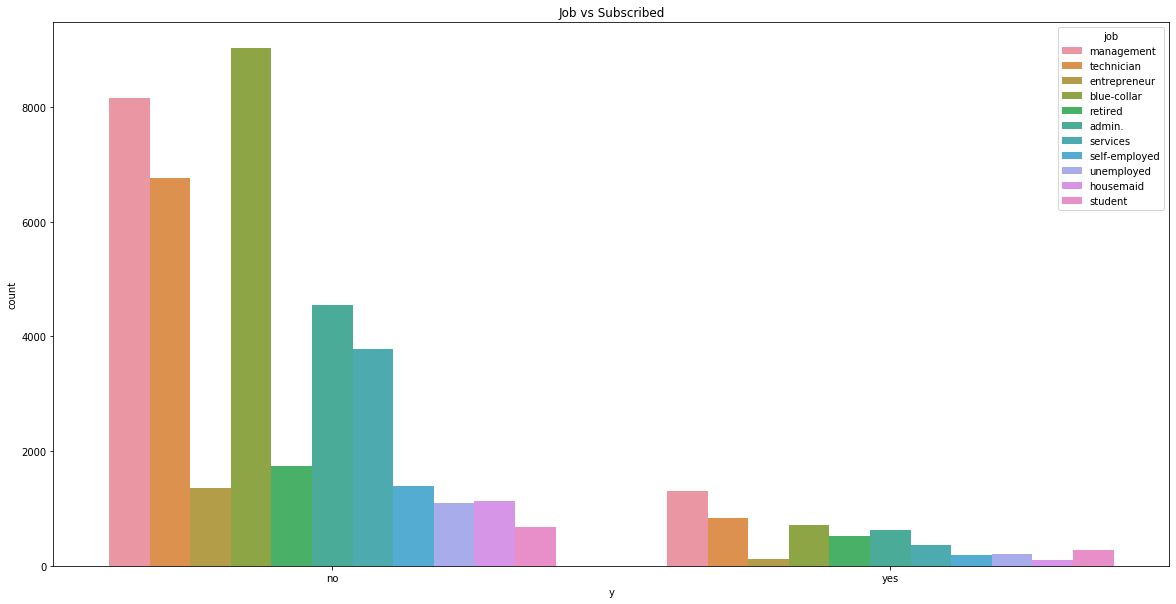

In [14]:
plt.figure(figsize=(20,10))
plt.title('Job vs Subscribed')
sns.countplot(df['y'],hue=df['job'])

#### Most of banking's customers are Management and blue-collar.
#### Even no. of Blue-collar in our database is slightly more than Management, Management and Technician are the groups with high subscription.
#### Among each group, student and retired have more chance to subscribe term deposit with 29% and 23% respectively.

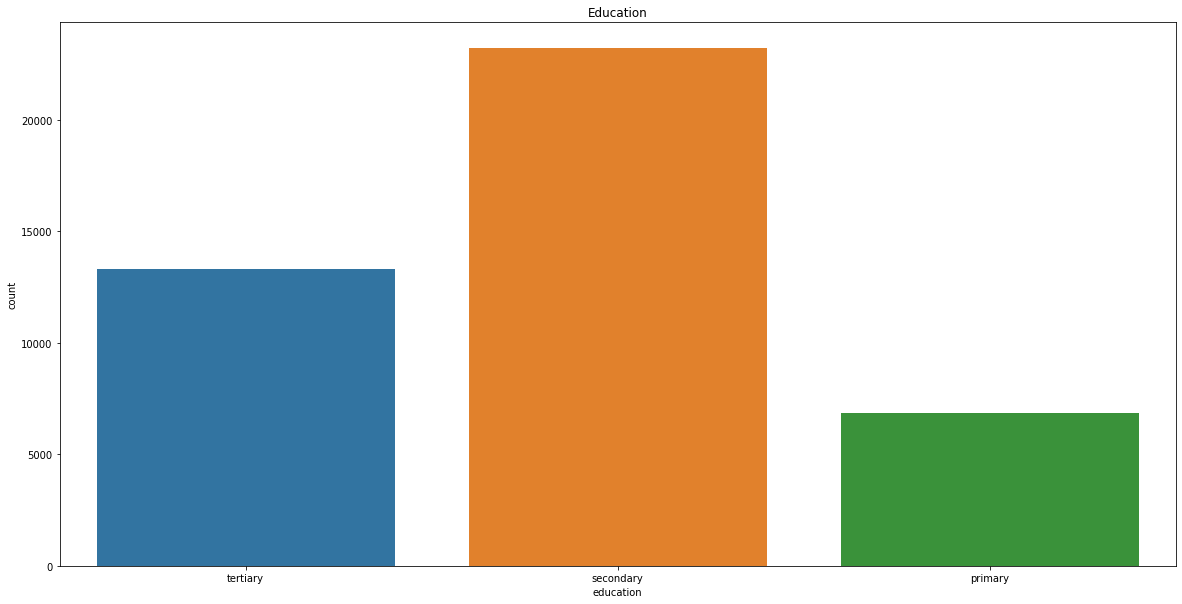

In [164]:
plt.figure(figsize=(20,10))
plt.title('Education')
sns.countplot(df['education'])

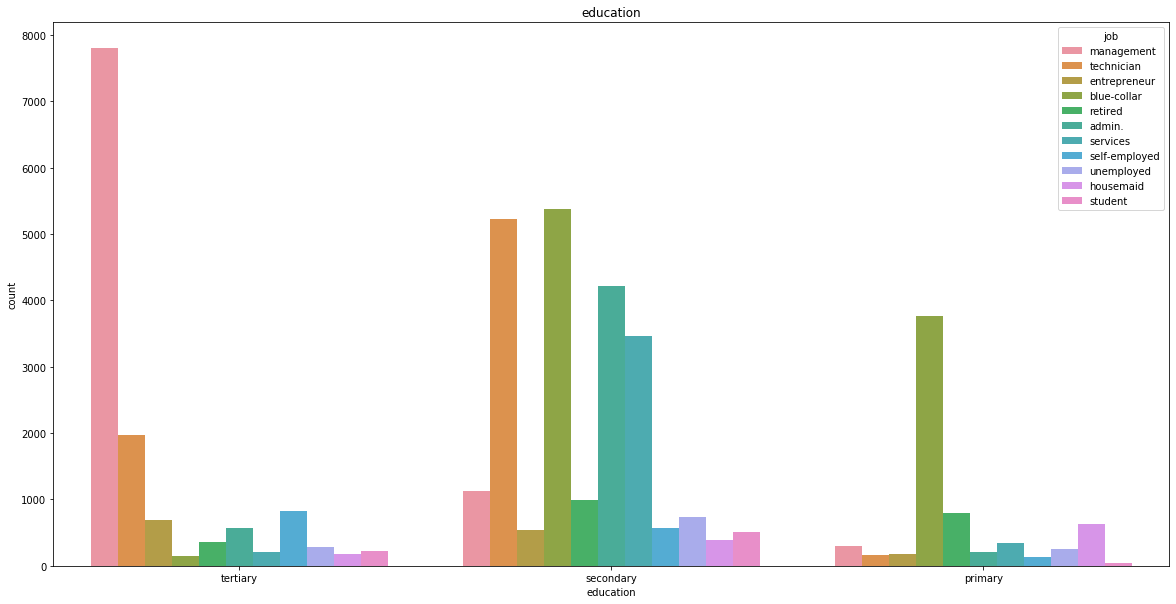

In [165]:
plt.figure(figsize=(20,10))
plt.title('education')
sns.countplot(df['education'],hue=df['job'])

#### It's not suprised that most customer who are in management level with tertiary level, while most customer who are blue-collar, with secondary or primary level.
#### Technician, Admin and Services are most likely with Secondary education.
#### Secondary Blue-collar is slightly more than primary Blue-colloar.
#### This is useful information for us to fill missing value in our database.

In [66]:
education_sub1=df.groupby(['y','education']).agg({'y':'count'})
education_sub1.columns=['ct']
education_sub1=education_sub1.reset_index()
education_sub2=education_sub1.pivot(index='education',columns='y',values='ct')
education_sub2=education_sub2.reset_index()
education_sub2['No']=education_sub2['no']/(education_sub2['no']+education_sub2['yes'])
education_sub2['Yes']=1-education_sub2['No']
education_sub2=education_sub2.drop(['no','yes'],axis=1)

In [67]:
education_sub2

y,education,No,Yes
0,primary,0.913735,0.086265
1,secondary,0.894406,0.105594
2,tertiary,0.849936,0.150064


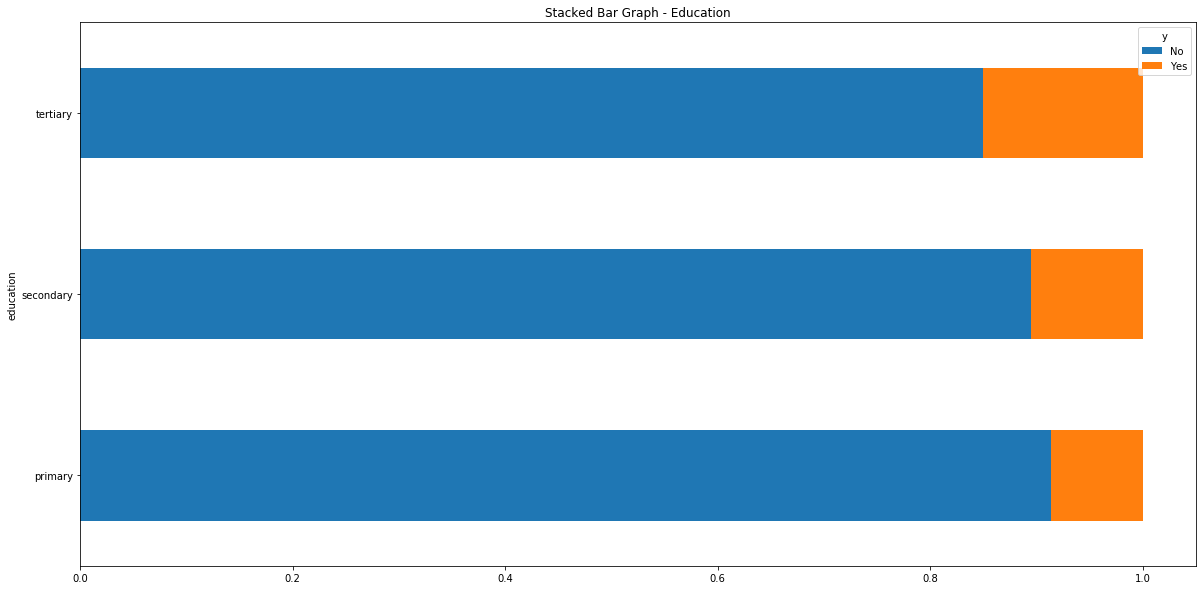

In [68]:
education_sub2.plot( 
    figsize=(20,10),
    x = 'education', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph - Education', 
    mark_right = True)

#### In our database, majority customer with secondary level, but among each education level, Tertiary has higher chance to subscribe term deposit.

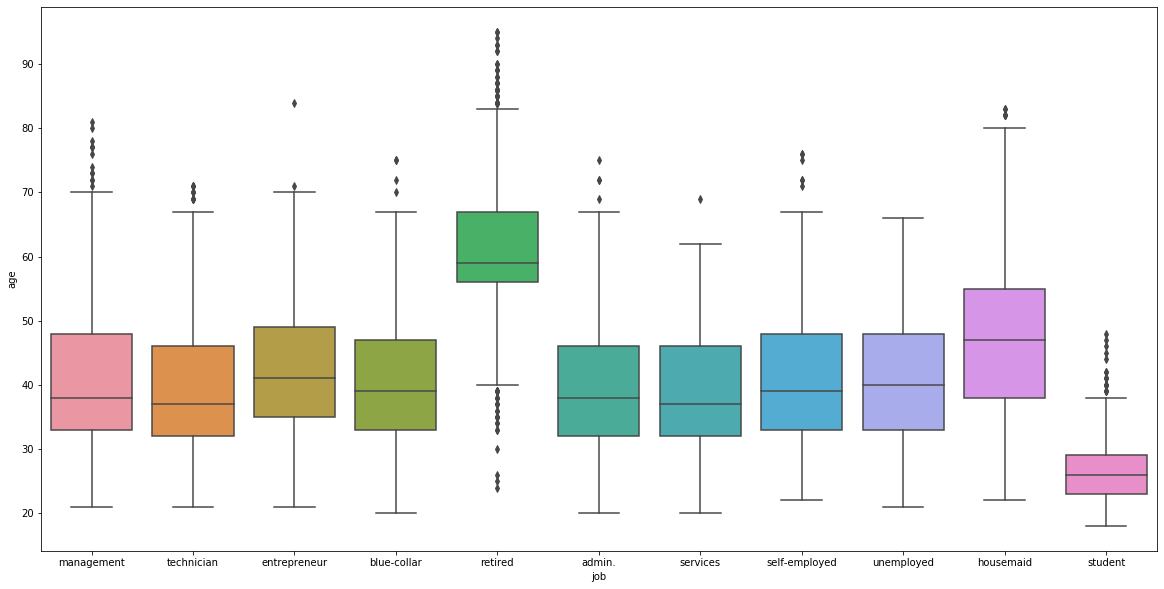

In [70]:
plt.figure(figsize=(20,10))
sns.boxplot(x='job', y='age',data=df)

#### It is not suprised that retired custoemer are older while student are younger.
#### Forcus on Management, Blue-collar and technician, we can see that their age are similar around 32 to 48.

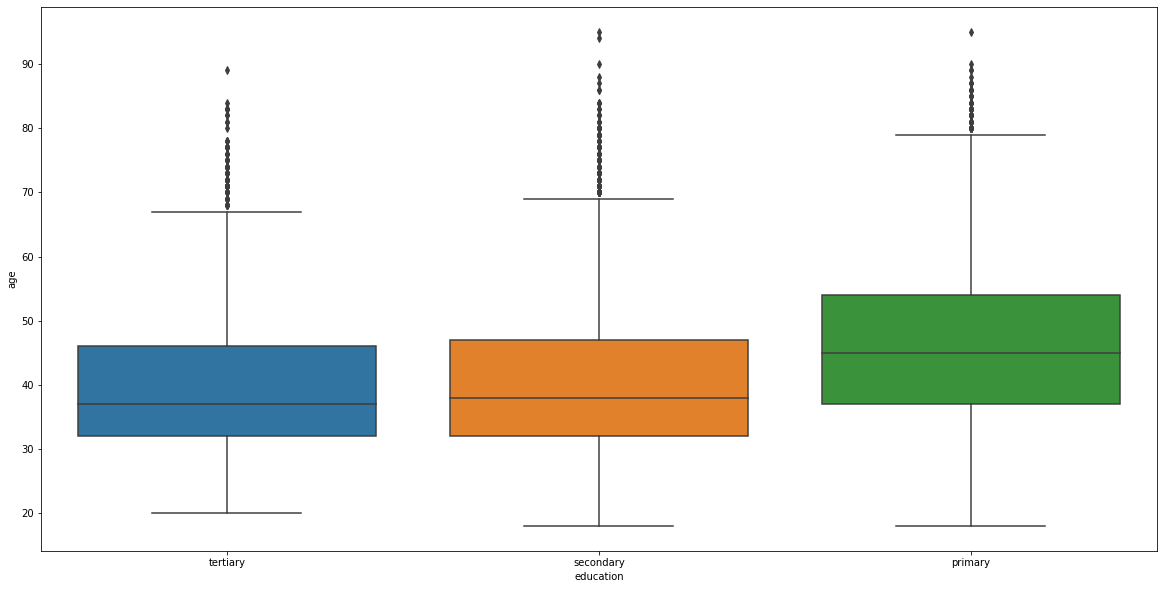

In [71]:
plt.figure(figsize=(20,10))
sns.boxplot(x='education', y='age',data=df)

#### We can see that customer with primary education level are relatively older while customer with teritiary level and secondary level are similar.

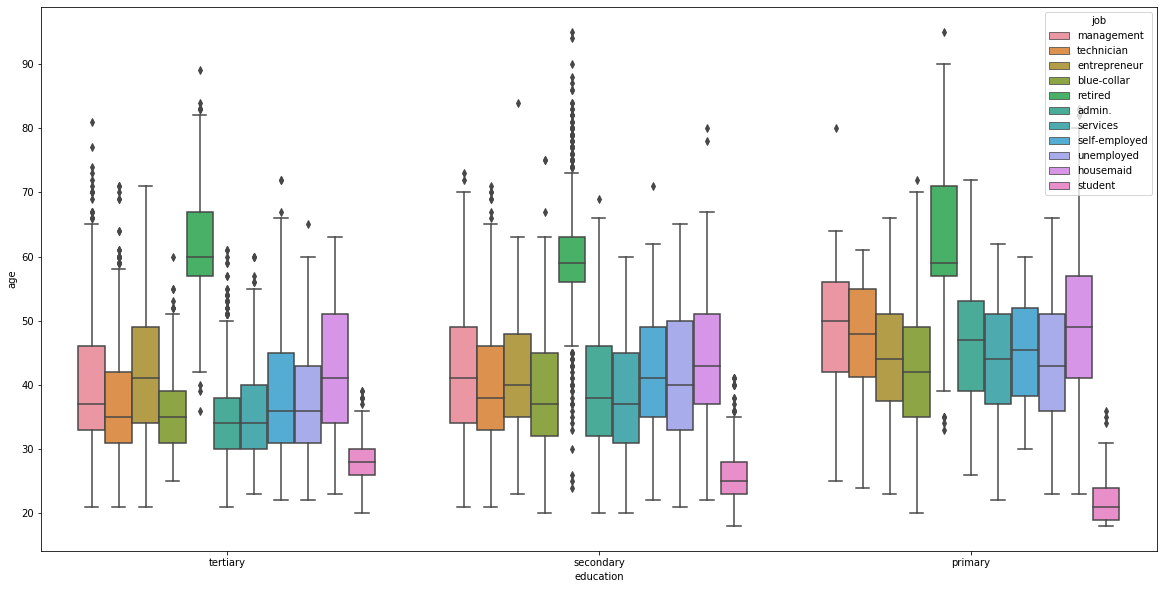

In [72]:
plt.figure(figsize=(20,10))
sns.boxplot(x='education', y='age',hue='job',data=df)

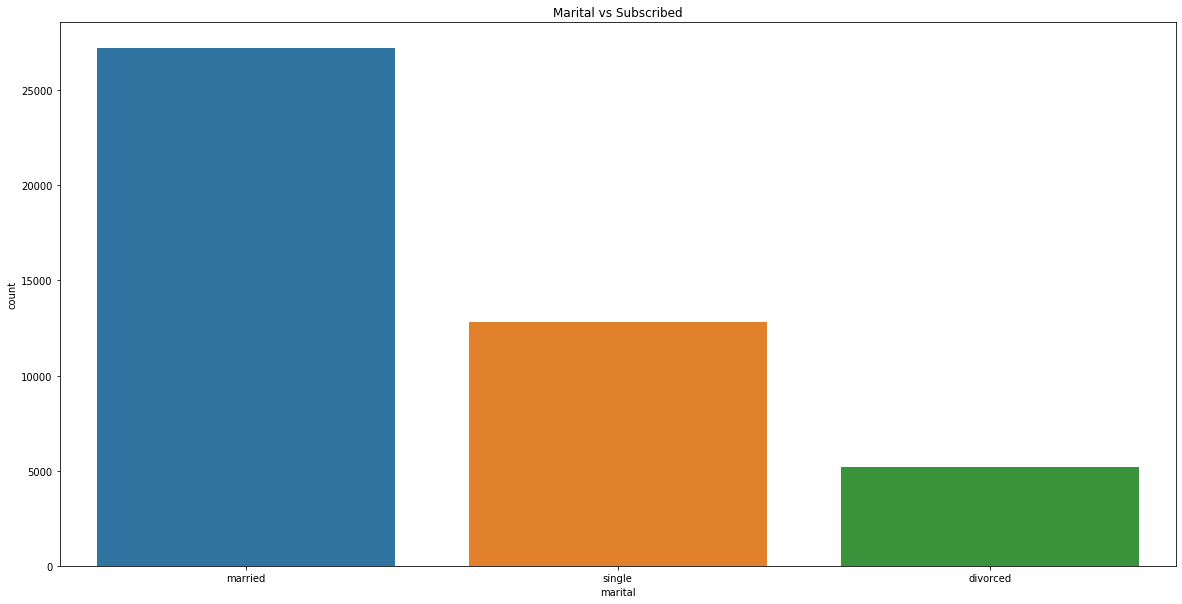

In [78]:
plt.figure(figsize=(20,10))
plt.title('Marital vs Subscribed')
sns.countplot(df['marital'])

In [74]:
marital_sub1=df.groupby(['y','marital']).agg({'y':'count'})
marital_sub1.columns=['ct']
marital_sub1=marital_sub1.reset_index()
marital_sub2=marital_sub1.pivot(index='marital',columns='y',values='ct')
marital_sub2=marital_sub2.reset_index()
marital_sub2['No']=marital_sub2['no']/(marital_sub2['no']+marital_sub2['yes'])
marital_sub2['Yes']=1-marital_sub2['No']
marital_sub2=marital_sub2.drop(['no','yes'],axis=1)

In [75]:
marital_sub2

y,marital,No,Yes
0,divorced,0.880545,0.119455
1,married,0.898765,0.101235
2,single,0.850508,0.149492


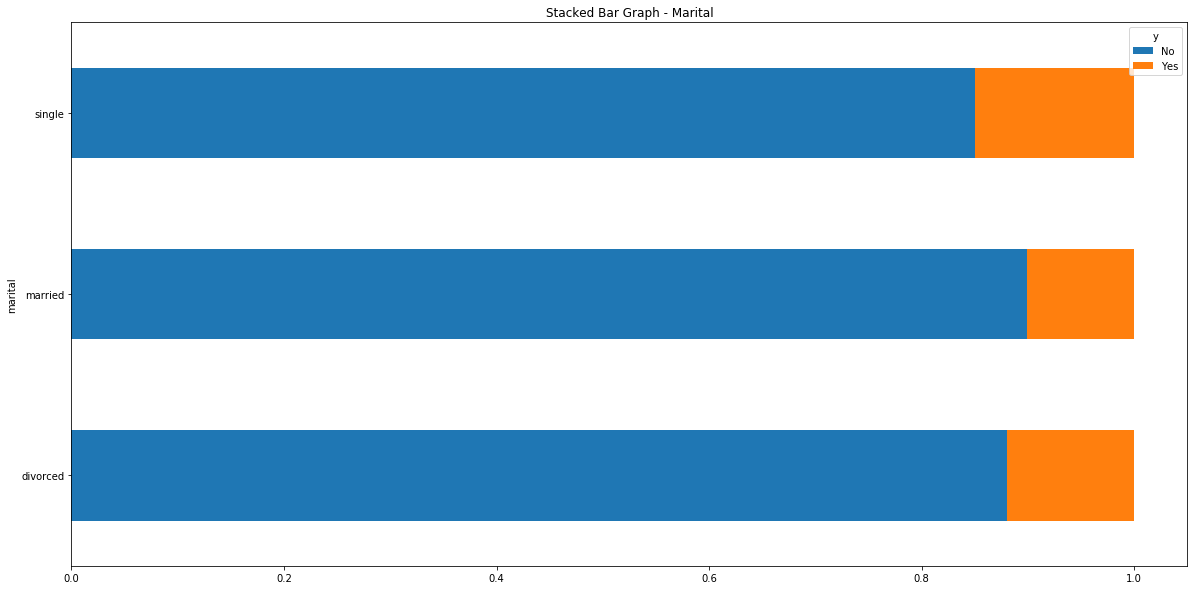

In [77]:
marital_sub2.plot( 
    figsize=(20,10),
    x = 'marital', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph - Marital', 
    mark_right = True)

#### From the above graph, we can see that even marjority of our customer are married followed by single and divorced, Term Deposit by single and divorced is more than married.

## Banking Service

In [89]:
def BankingService(default,housing,loan):
    if (default=='yes') & (housing=='no') & (loan=='no'):
        return '1. Default only'
    elif (default=='no') & (housing=='yes') & (loan=='no'):
        return '2. Housing only'
    elif (default=='no') & (housing=='no') & (loan=='yes'):
        return '3. Loan only'
    elif (default=='yes') & (housing=='yes') & (loan=='no'):
        return '4. Default and Housing'
    elif (default=='no') & (housing=='yes') & (loan=='yes'):
        return '5.  Housing and Loan'
    elif (default=='yes') & (housing=='no') & (loan=='yes'):
        return '6. Default and Loan'
    elif (default=='yes') & (housing=='yes') & (loan=='yes'):
        return '7. Default and Housing and Loan'
    else:
        return '8. No Service'

In [105]:
df['BankService']=df[['default','housing','loan']].apply(lambda x:BankingService(*x),axis=1)

In [124]:
bs_sub1=df.groupby(['y','BankService']).agg({'y':'count'})
bs_sub1.columns=['ct']
bs_sub1=bs_sub1.reset_index()
bs_sub2=bs_sub1.pivot(index='BankService',columns='y',values='ct')
bs_sub2=bs_sub2.reset_index()
bs_sub2['No']=bs_sub2['no']/(bs_sub2['no']+bs_sub2['yes'])
bs_sub2['Yes']=1-bs_sub2['No']
bs_sub2=bs_sub2.drop(['no','yes'],axis=1)

In [125]:
bs_sub2

y,BankService,No,Yes
0,1. Default only,0.929245,0.070755
1,2. Housing only,0.919457,0.080543
2,3. Loan only,0.922111,0.077889
3,4. Default and Housing,0.927152,0.072848
4,5. Housing and Loan,0.939065,0.060935
5,6. Default and Loan,0.952381,0.047619
6,7. Default and Housing and Loan,0.947368,0.052632
7,8. No Service,0.816384,0.183616


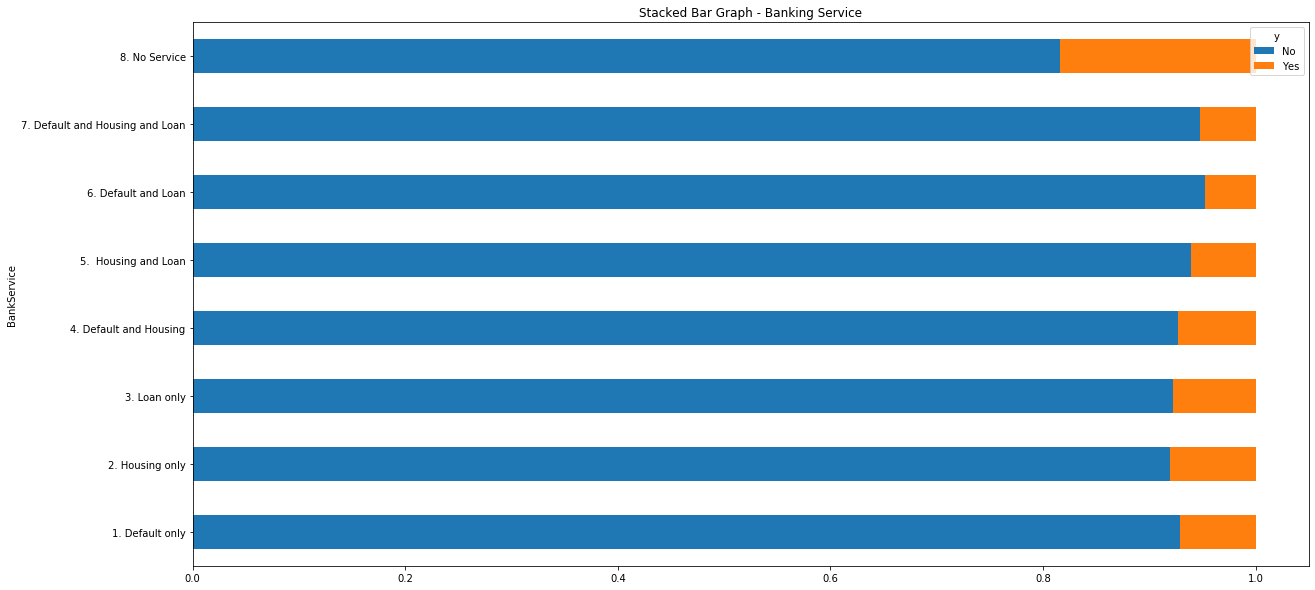

In [127]:
bs_sub2.plot( 
    figsize=(20,10),
    x = 'BankService', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph - Banking Service', 
    mark_right = True)

In [143]:
bs_summary1=df.groupby(['y','BankService']).agg({'balance':['mean','median']})
bs_summary1=bs_summary1.reset_index()
bs_summary1
bs_summary1.pivot_table(index='BankService',columns='y',values='balance')

C:\Users\Catherine\anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


mean              median       
y                                         no          yes     no    yes
BankService                                                            
1. Default only                   -17.944162   -11.866667    0.0    3.0
2. Housing only                  1250.131080  1593.995146  442.0  663.0
3. Loan only                      784.297438  1091.241706  258.5  409.0
4. Default and Housing           -199.875000  -130.000000 -101.0 -147.0
5.  Housing and Loan              822.864437   765.856589  294.0  264.5
6. Default and Loan              -151.756250    51.250000    0.0    0.0
7. Default and Housing and Loan  -199.880952   -81.428571 -189.5 -274.0
8. No Service                    1687.303561  2080.520513  535.5  925.0

#### Customer without any banking service has higher chance to subscribe term deposit.
#### For those with banking service, customer with only 1 banking service or with both 'Default and Housing' Service are more likely to subscribe term deposit.
#### Customer has higher balance are more likely to subscribe term deposit.

## Contact History

In [146]:
df.groupby('contact').agg({'contact':['count']})

,contact
,count
contact,
cellular,29285
telephone,2906


#### The bank use celluar 10 times more than telephone

In [147]:
df[df['contact']=='cellular']['contact'].count()/df[(df['contact']=='cellular')|(df['contact']=='telephone')]['contact'].count()

0.9097263210214035

In [148]:
def Month(month):
    if month=='jan':
        return 1
    elif month=='feb':
        return 2
    elif month=='mar':
        return 3
    elif month=='apr':
        return 4
    elif month=='may':
        return 5
    elif month=='jun':
        return 6
    elif month=='jul':
        return 7
    elif month=='aug':
        return 8
    elif month=='sep':
        return 9
    elif month=='oct':
        return 10
    elif month=='nov':
        return 11
    elif month=='dec':
        return 12

In [149]:
df['Month']=df['month'].apply(Month)

In [150]:
Contact_Month=df.groupby(['Month','contact']).agg({'contact':'count'})
Contact_Month.columns=['Contact_Time']
Contact_Month=Contact_Month.reset_index()
SummaryMonth=Contact_Month.pivot(index='Month',columns='contact',values='Contact_Time')
SummaryMonth.T

Month,1,2,3,4,5,6,7,8,9,10,11,12
contact,,,,,,,,,,,,
cellular,1265,2362,417,2727,5331,729,5767,5950,466,557,3540,174
telephone,129,274,53,199,460,80,852,246,66,131,379,37


In [152]:
Contact_Day=df.groupby(['day','contact']).agg({'contact':'count'})
Contact_Day.columns=['Contact_Time']
Contact_Day=Contact_Day.reset_index()
SummaryDay=Contact_Day.pivot(index='day',columns='contact',values='Contact_Time')

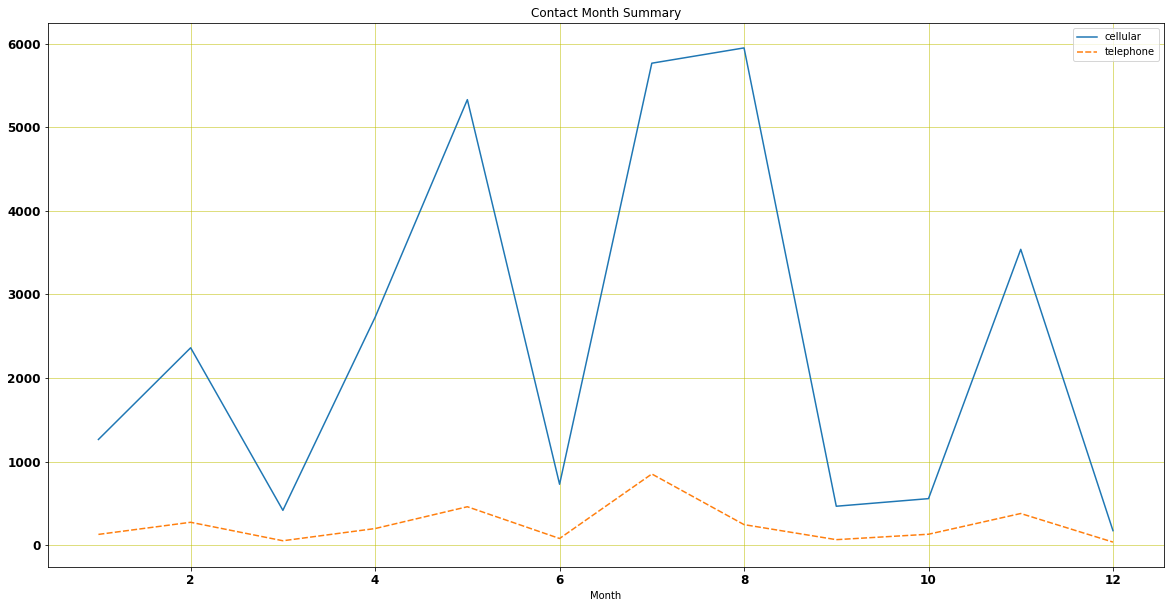

In [153]:
plt.figure(figsize=(20,10))
plt.title('Contact Month Summary') #Add Title
sns.lineplot(data=SummaryMonth)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

In [154]:
def week(day):
    if day>=1 and day<=8:
        return 1
    elif day>=9 and day<=15:
        return 2
    elif day>=16 and day<=22:
        return 3
    elif day>=23:
        return 4

In [155]:
df['Week']=df['day'].apply(week)

In [156]:
Contact_Week=df.groupby(['Week','contact']).agg({'contact':'count'})
Contact_Week.columns=['Contact_Time']
Contact_Week=Contact_Week.reset_index()
SummaryWeek=Contact_Week.pivot(index='Week',columns='contact',values='Contact_Time')
SummaryWeek.T

Week,1,2,3,4
contact,,,,
cellular,7313,6712,8925,6335
telephone,659,721,734,792


In [157]:
df['Month_Week']=df['month'].str.upper()+' Week '+df['Week'].astype('str')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

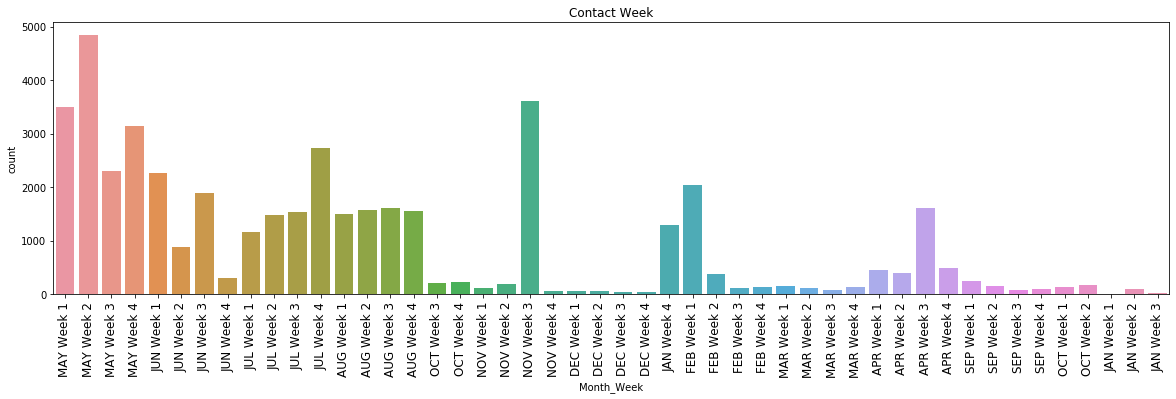

In [158]:
plt.figure(figsize=(20,5))
plt.title('Contact Week')
sns.countplot(df['Month_Week'])
plt.xticks(fontsize=12,rotation=90) # x-axis fontsize's style

#### From the above graph, we can see that we contact our customers mostly on May, Jul, Aug an Nov last year.
#### Among them, contact on May, Jul and Nov are focus on week 2, week 4 and week 3 respectively, while contact on Aug is evenly.

In [159]:
df[df['contact'].isnull()==True].groupby('Month').agg({'Month':'count'}).T

Month,1,2,3,4,5,6,7,8,9,10,11,12
Month,9,13,7,6,7975,4532,276,51,47,50,51,3


#### Here, we can see that most of contact's missing value are on May and Jun.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

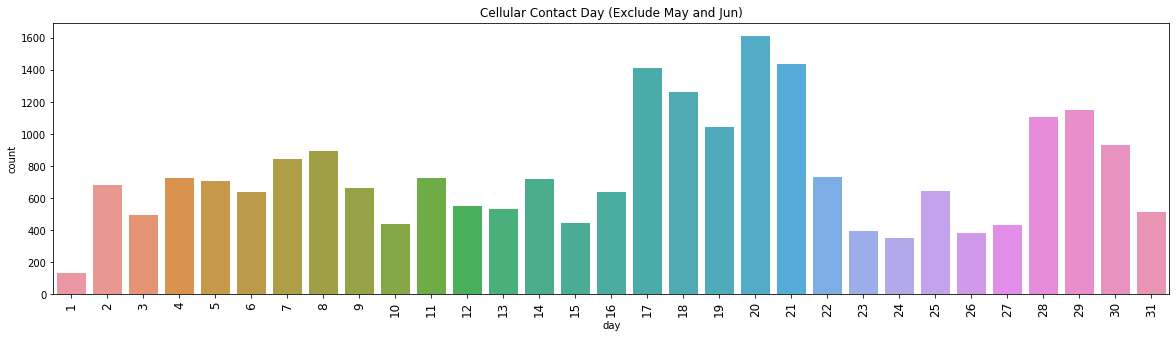

In [160]:
May_C=df[(df['contact']=='cellular') & (df['Month']!=5) & (df['Month']!=6)]
plt.figure(figsize=(20,5))
plt.title('Cellular Contact Day (Exclude May and Jun)')
sns.countplot(May_C['day'])
plt.xticks(fontsize=12,rotation=90) # x-axis fontsize's style

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

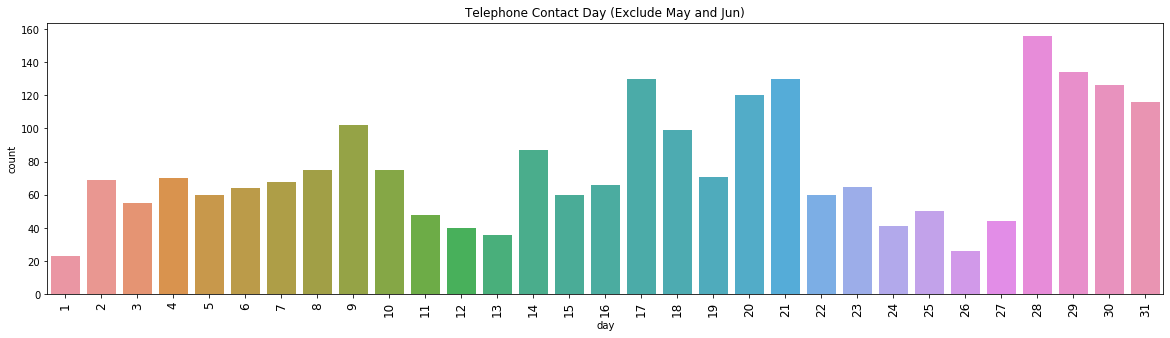

In [161]:
May_T=df[(df['contact']=='telephone') & (df['Month']!=5) & (df['Month']!=6)]
plt.figure(figsize=(20,5))
plt.title('Telephone Contact Day (Exclude May and Jun)')
sns.countplot(May_T['day'])
plt.xticks(fontsize=12,rotation=90) # x-axis fontsize's style

In [162]:
sub_month=df.groupby(['y','Month']).agg({'Month':'count'})
sub_month.columns=['ct']
sub_month=sub_month.reset_index()
sub_month2=sub_month.pivot(index='y',columns='Month',values='ct')
sub_month2

Month,1,2,3,4,5,6,7,8,9,10,11,12
y,,,,,,,,,,,,
no,1261,2208,229,2355,12841,4795,6268,5559,310,415,3567,114
yes,142,441,248,577,925,546,627,688,269,323,403,100


In [163]:
sub_month2.iloc[1,:]/(sub_month2.iloc[0,:]+sub_month2.iloc[1,:])

Month
1     0.101212
2     0.166478
3     0.519916
4     0.196794
5     0.067195
6     0.102228
7     0.090935
8     0.110133
9     0.464594
10    0.437669
11    0.101511
12    0.467290
dtype: float64

#### Here, we can see that Most subscription is made on Mar, Sep, Oct, Dec while May, Jul, Aug Nov has the less subscription.

In [164]:
sub_week=df.groupby(['y','Week']).agg({'Week':'count'})
sub_week.columns=['ct']
sub_week=sub_week.reset_index()
sub_week2=sub_week.pivot(index='y',columns='Week',values='ct')
sub_week2

Week,1,2,3,4
y,,,,
no,10206,8889,11837,8990
yes,1434,1414,1265,1176


In [165]:
sub_week2.iloc[1,:]/(sub_week2.iloc[0,:]+sub_week2.iloc[1,:])

Week
1    0.123196
2    0.137242
3    0.096550
4    0.115680
dtype: float64

In [166]:
# In second, 60s= 1 min
def duration_group(duration):
    if (duration>=0) and (duration<300):
        return '1. 0-5 mins'
    elif (duration>=300) and (duration<600):
        return '2. 5-10 mins'
    elif (duration>=600) and (duration<900):
        return '3. 10-15 mins'
    elif (duration>=900):
        return '4. >15 mins'
    

In [167]:
df['Duration']=df['duration'].apply(duration_group)

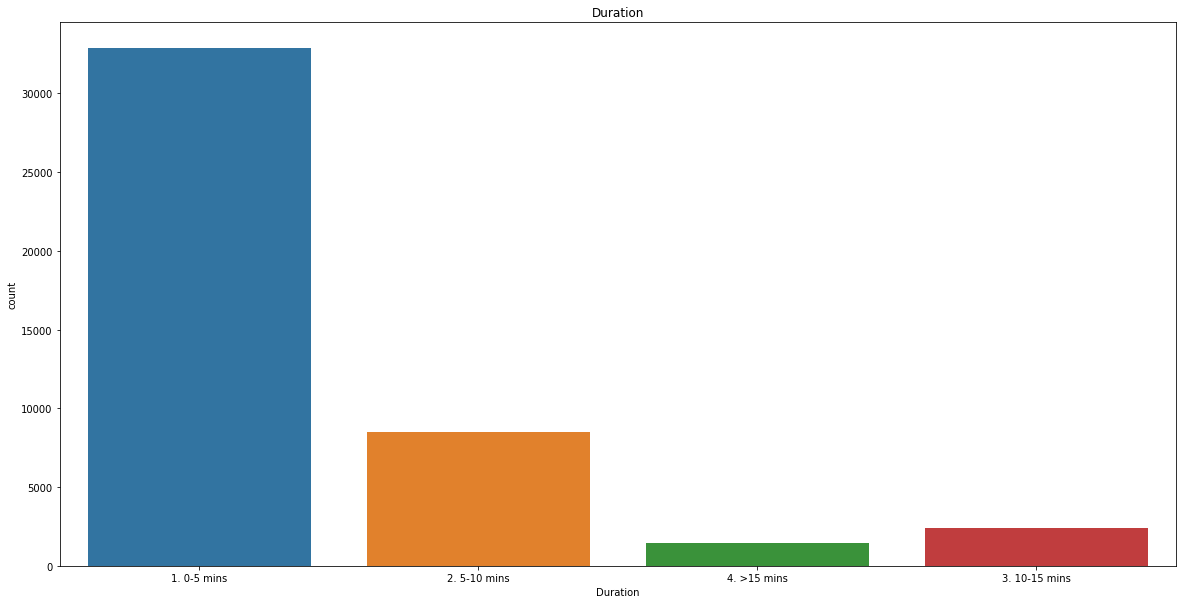

In [168]:
plt.figure(figsize=(20,10))
plt.title('Duration')
sns.countplot(df['Duration'])

In [170]:
dur_sub1=df.groupby(['y','Duration']).agg({'y':'count'})
dur_sub1.columns=['ct']
dur_sub1=dur_sub1.reset_index()
dur_sub2=dur_sub1.pivot(index='Duration',columns='y',values='ct')
dur_sub2=dur_sub2.reset_index()
dur_sub2['No']=dur_sub2['no']/(dur_sub2['no']+dur_sub2['yes'])
dur_sub2['Yes']=1-dur_sub2['No']
dur_sub2=dur_sub2.drop(['no','yes'],axis=1)

In [171]:
dur_sub2

y,Duration,No,Yes
0,1. 0-5 mins,0.944590,0.055410
1,2. 5-10 mins,0.808843,0.191157
2,3. 10-15 mins,0.581864,0.418136
3,4. >15 mins,0.407746,0.592254


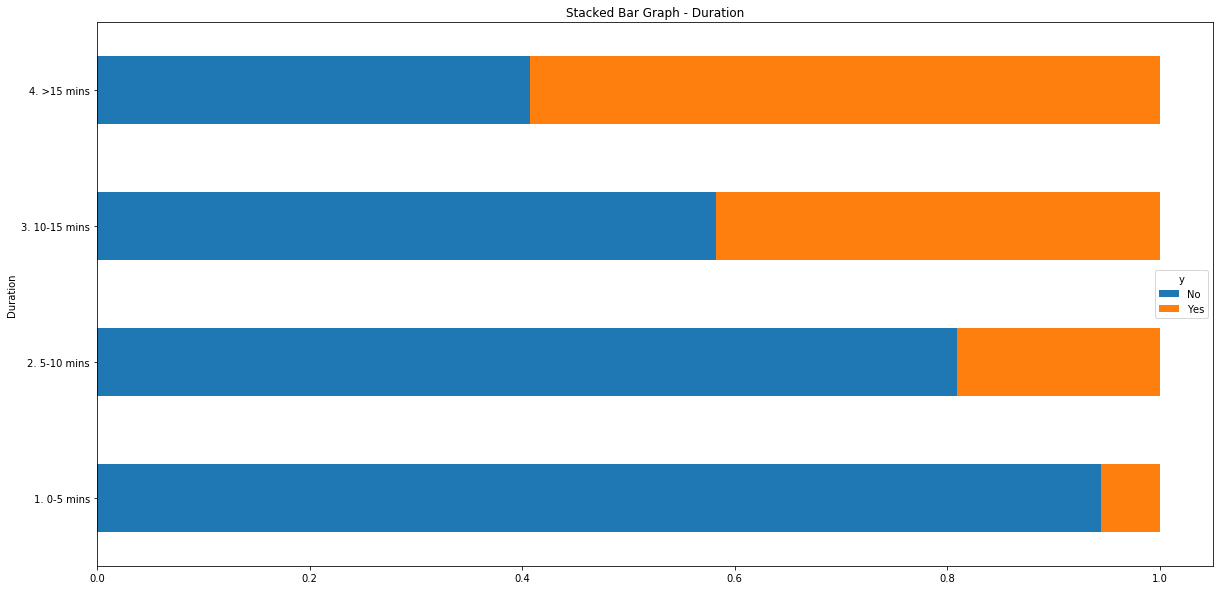

In [172]:
dur_sub2.plot( 
    figsize=(20,10),
    x = 'Duration', 
    kind = 'barh', 
    stacked = True, 
    title = 'Stacked Bar Graph - Duration', 
    mark_right = True)

#### Most duration of a call is within 0-5 mins. We can see that the longer the duration, the more chance the customer will subscribe the term deposit.

previous     1       2      3      4      5      6      7     8     9     10   \
poutcome                                                                        
failure   1707.0  1362.0  660.0  405.0  261.0  146.0  101.0  54.0  49.0  28.0   
other      591.0   390.0  238.0  165.0  107.0   64.0   59.0  46.0  27.0  19.0   
success    473.0   352.0  244.0  144.0   90.0   67.0   44.0  29.0  16.0  20.0   

previous   11    12    13   14    15   16   17   18   19   20   21   22   23   \
poutcome                                                                        
failure   26.0  22.0  16.0  7.0   9.0  7.0  6.0  1.0  7.0  3.0  1.0  2.0  3.0   
other     27.0  17.0  16.0  7.0  10.0  6.0  9.0  5.0  4.0  5.0  2.0  3.0  5.0   
success   12.0   5.0   6.0  5.0   1.0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  NaN   

previous  24   25   26   27   28   29   30   32   35   37   38   40   41   \
poutcome                                                                    
failure   1.0  3.0  1.0  2.0  1.0 

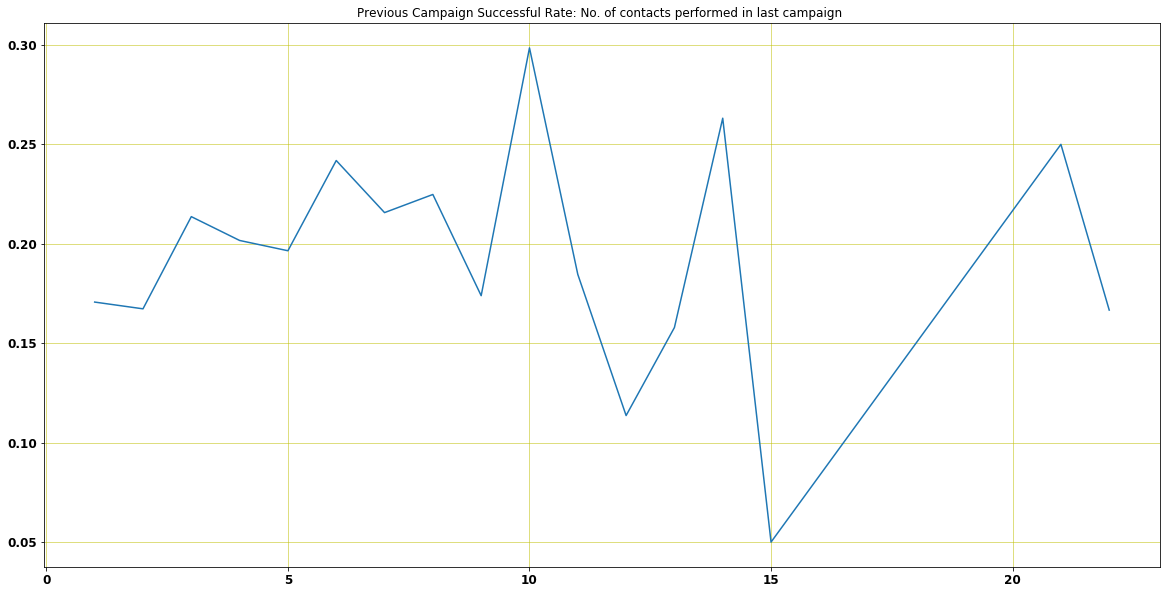

In [210]:
p_contact=df[df['pdays']>-1]

sub_previous=p_contact.groupby(['poutcome','previous']).agg({'previous':'count'})
sub_previous.columns=['ct']
sub_previous=sub_previous.reset_index()
sub_previous2=sub_previous.pivot(index='poutcome',columns='previous',values='ct')
sub_previous3=sub_previous2.loc['success',:]/(sub_previous2.loc['success',:]+sub_previous2.loc['failure',:]+sub_previous2.loc['other',:])
print(sub_previous2)

plt.figure(figsize=(20,10))
plt.title('Previous Campaign Successful Rate: No. of contacts performed in last campaign ') #Add Title
sns.lineplot(data=sub_previous3)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

#### Here is the result of last campaign.
#### It seems that contact less than 10 times are more likely the customer will accept the offer.
#### If we call more than 10 times, the efficient rate drops, even we can see that it has a peak in around 14 and 21 times, which are some extreme cases.

campaign       1       2       3       4       5       6      7      8   \
y                                                                         
no        12006.0  9333.0  4209.0  2853.0  1405.0  1057.0  597.0  458.0   
yes        1523.0   896.0   399.0   244.0   103.0    71.0   41.0   28.0   

campaign     9      10     11     12     13    14    15    16    17    18  \
y                                                                           
no        284.0  242.0  174.0  144.0  125.0  88.0  79.0  76.0  63.0  51.0   
yes        19.0   14.0   15.0    4.0    6.0   4.0   4.0   2.0   6.0   NaN   

campaign    19    20    21    22    23    24    25    26    27    28    29  \
y                                                                            
no        44.0  42.0  34.0  23.0  22.0  19.0  22.0  13.0  10.0  16.0  15.0   
yes        NaN   1.0   1.0   NaN   NaN   1.0   NaN   NaN   NaN   NaN   1.0   

campaign   30    31   32   33   34   35   36   37   38   39   41   43   44  \

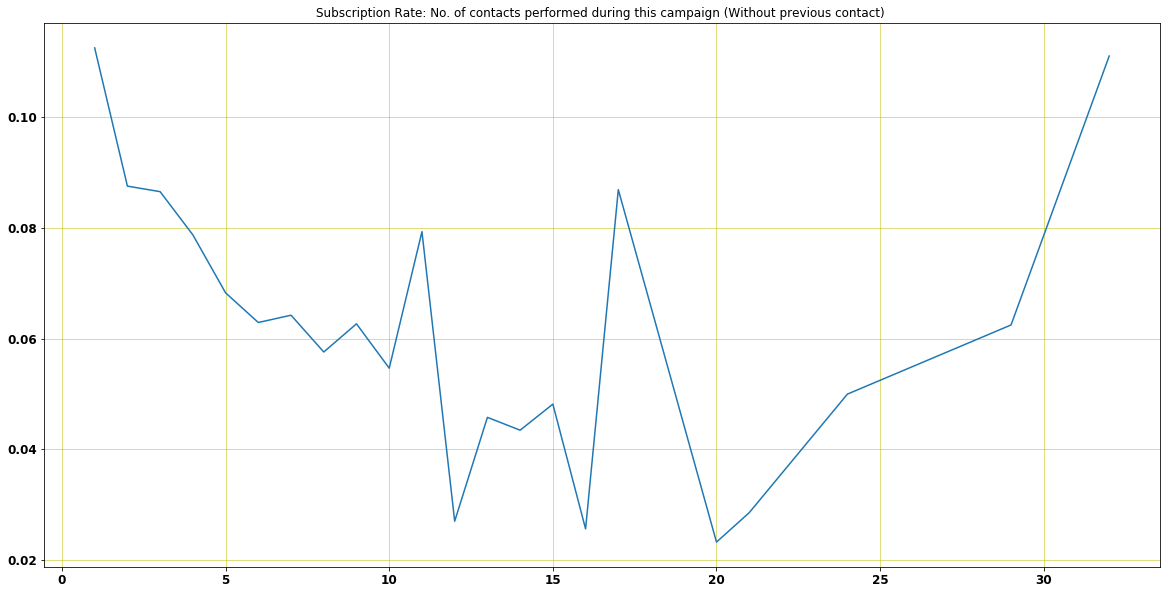

In [211]:
p_contact=df[df['pdays']==-1]

sub_campaign=p_contact.groupby(['y','campaign']).agg({'campaign':'count'})
sub_campaign.columns=['ct']
sub_campaign=sub_campaign.reset_index()
sub_campaign2=sub_campaign.pivot(index='y',columns='campaign',values='ct')
sub_campaign3=sub_campaign2.iloc[1,:]/(sub_campaign2.iloc[0,:]+sub_campaign2.iloc[1,:])

print(sub_campaign2)


plt.figure(figsize=(20,10))
plt.title('Subscription Rate: No. of contacts performed during this campaign (Without previous contact) ') #Add Title
sns.lineplot(data=sub_campaign3)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

campaign     1      2      3     4     5     6     7    8    9    11
y                                                                   
no        280.0  144.0   44.0  23.0  18.0   7.0  10.0  6.0  1.0  NaN
yes       557.0  258.0  105.0  28.0  12.0  14.0   1.0  2.0  NaN  1.0


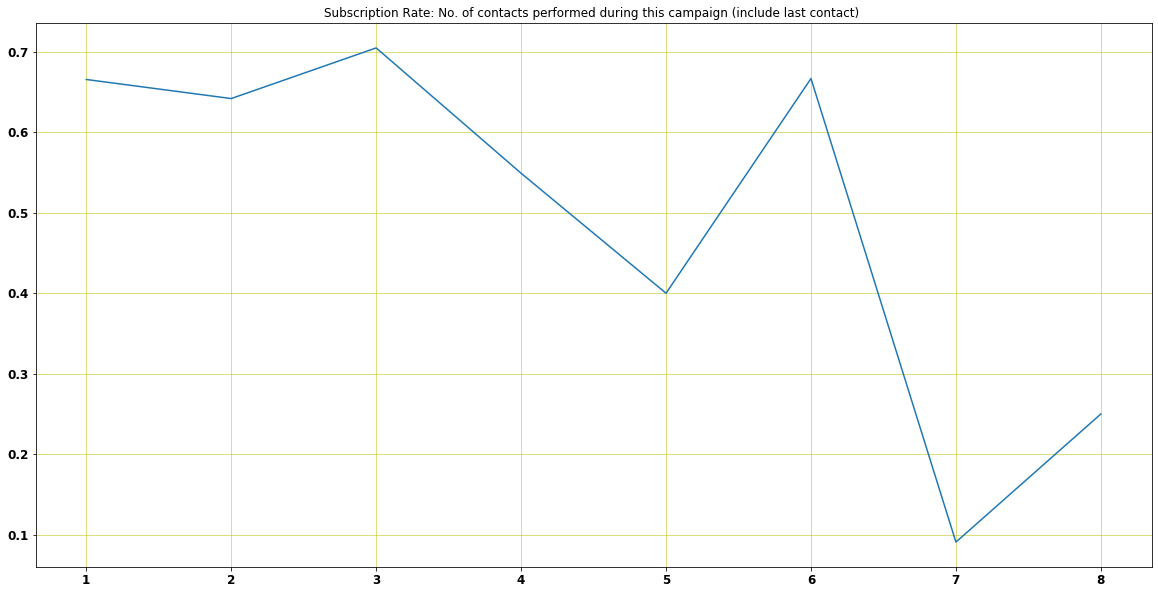

In [212]:
poutcome_s=df[(df['poutcome']=='success') & (df['pdays']>-1)]

sub_campaign=poutcome_s.groupby(['y','campaign']).agg({'campaign':'count'})
sub_campaign.columns=['ct']
sub_campaign=sub_campaign.reset_index()
sub_campaign2=sub_campaign.pivot(index='y',columns='campaign',values='ct')
sub_campaign3=sub_campaign2.iloc[1,:]/(sub_campaign2.iloc[0,:]+sub_campaign2.iloc[1,:])

print(sub_campaign2)


plt.figure(figsize=(20,10))
plt.title('Subscription Rate: No. of contacts performed during this campaign (include last contact) ') #Add Title
sns.lineplot(data=sub_campaign3)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

campaign     1      2      3      4     5     6     7     8     9    10   11  \
y                                                                              
no        581.0  413.0  218.0  111.0  77.0  51.0  31.0  23.0  11.0  4.0  7.0   
yes       137.0   87.0   44.0   20.0   9.0   4.0   3.0   1.0   2.0  NaN  NaN   

campaign   12   13   16  
y                        
no        4.0  1.0  1.0  
yes       NaN  NaN  NaN  


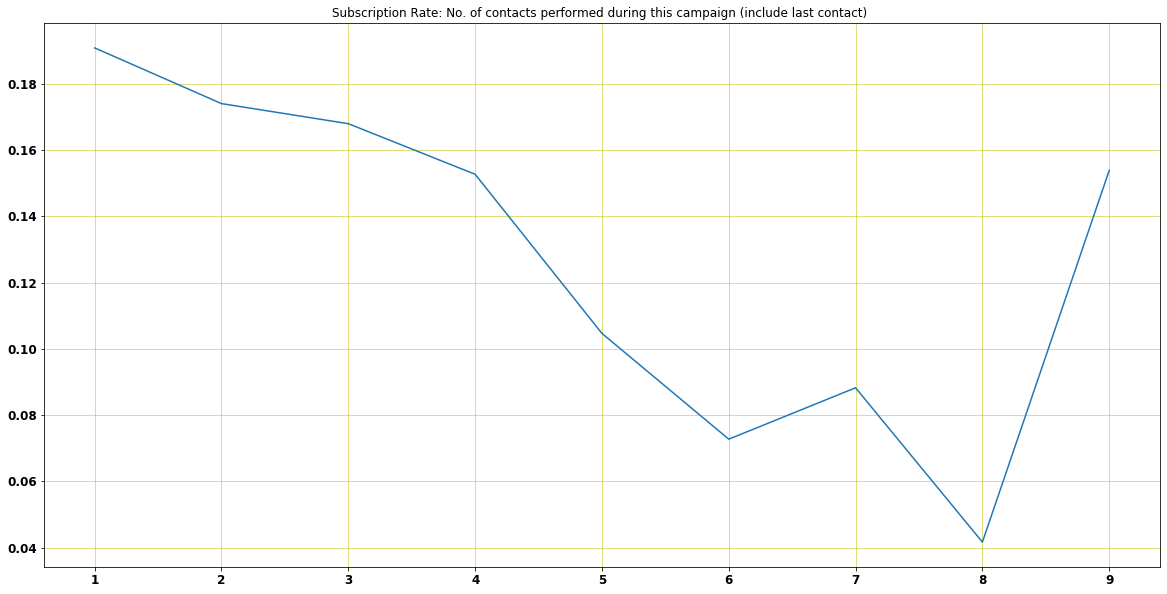

In [213]:
poutcome_o=df[df['poutcome']=='other']

sub_campaign=poutcome_o.groupby(['y','campaign']).agg({'campaign':'count'})
sub_campaign.columns=['ct']
sub_campaign=sub_campaign.reset_index()
sub_campaign2=sub_campaign.pivot(index='y',columns='campaign',values='ct')
sub_campaign3=sub_campaign2.iloc[1,:]/(sub_campaign2.iloc[0,:]+sub_campaign2.iloc[1,:])

print(sub_campaign2)


plt.figure(figsize=(20,10))
plt.title('Subscription Rate: No. of contacts performed during this campaign (include last contact) ') #Add Title
sns.lineplot(data=sub_campaign3)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

campaign      1       2      3      4      5     6     7     8     9    10  \
y                                                                            
no        2115.0  1214.0  430.0  218.0  125.0  84.0  50.0  21.0  10.0  6.0   
yes        343.0   160.0   70.0   24.0   15.0   3.0   2.0   1.0   NaN  NaN   

campaign   11   12   13   14   15  
y                                  
no        4.0  3.0  1.0  1.0  1.0  
yes       NaN  NaN  NaN  NaN  NaN  


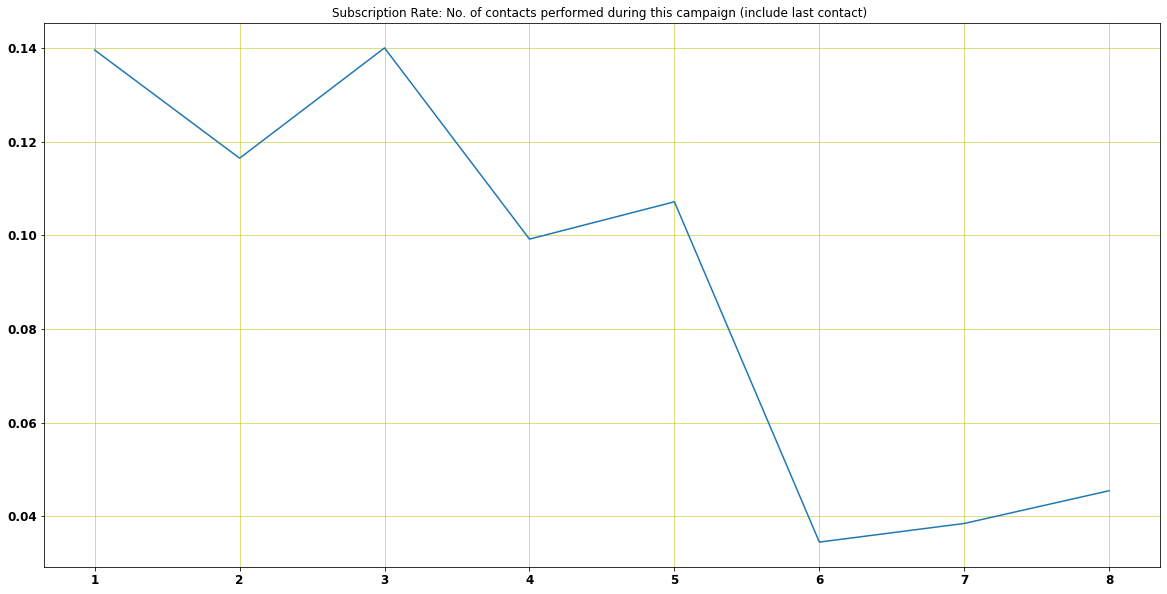

In [214]:
poutcome_f=df[df['poutcome']=='failure']

sub_campaign=poutcome_f.groupby(['y','campaign']).agg({'campaign':'count'})
sub_campaign.columns=['ct']
sub_campaign=sub_campaign.reset_index()
sub_campaign2=sub_campaign.pivot(index='y',columns='campaign',values='ct')
sub_campaign3=sub_campaign2.iloc[1,:]/(sub_campaign2.iloc[0,:]+sub_campaign2.iloc[1,:])

print(sub_campaign2)


plt.figure(figsize=(20,10))
plt.title('Subscription Rate: No. of contacts performed during this campaign (include last contact) ') #Add Title
sns.lineplot(data=sub_campaign3)
plt.xticks(weight='bold',fontsize=12) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

#### For the above graphs we can see that customer who accept the previous campaign have higher chance (40-70%) to subscribe the term deposit within 6 contact calls.
#### For those without any contact before and not accept or reject offer last time, it's only have less than 20% chance to subscribe the term deposit. 

In [215]:
def lastcall(pdays):
    if pdays==-1:
        return '1. No contact before'
    elif pdays>-1 and pdays<=30:
        return '2. Call within 1 Month'
    elif pdays>30 and pdays<=60:
        return '3. Call within 1 -2 Month'
    elif pdays>60 and pdays<=90:
        return '4. Call within 2 -3 Month'
    elif pdays>90 and pdays<=180:
        return '5. Call within 4 -6 Month'
    elif pdays>180 and pdays<=360:
        return '6. Call within 6 -12 Month'
    elif pdays>360 and pdays<=540:
        return '7. Call within 12 -18 Month'
    else:
        return '8. Call before more than 18 Month'

In [216]:
df['pMonths']=df['pdays'].apply(lastcall)

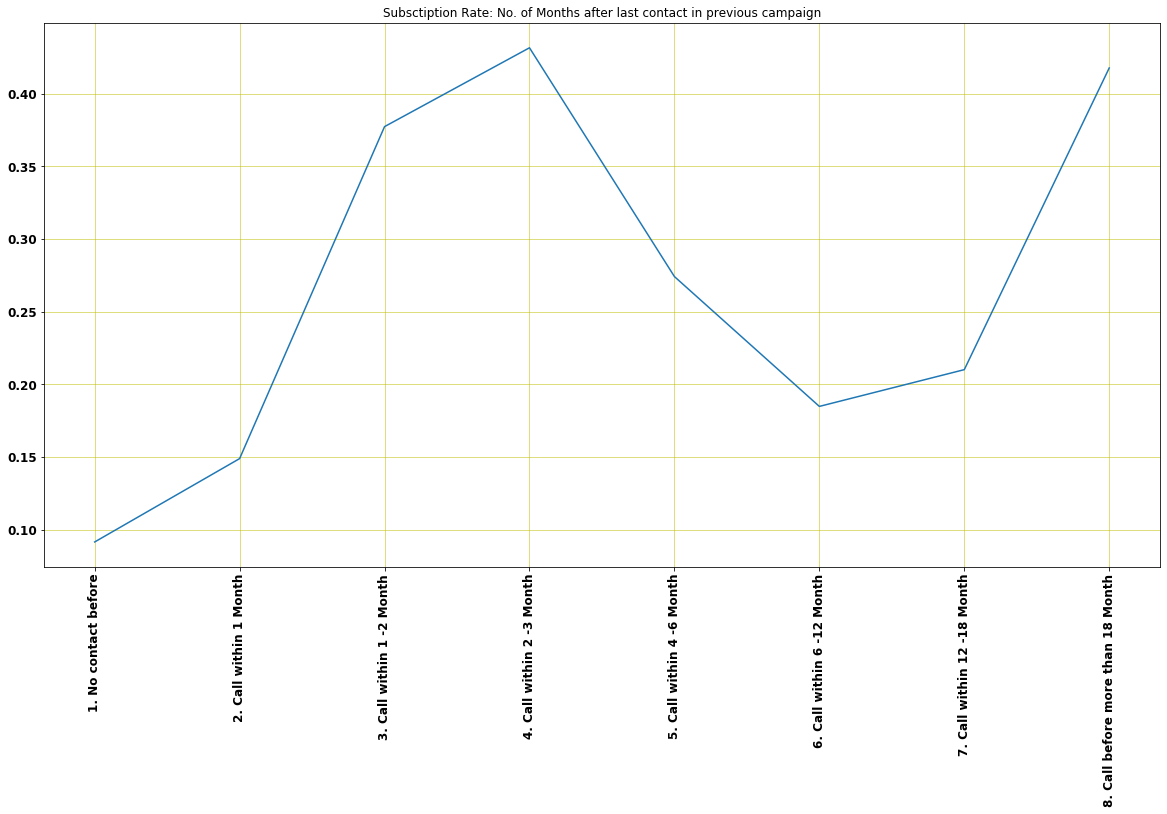

In [218]:
sub_pMonths=df.groupby(['y','pMonths']).agg({'pMonths':'count'})
sub_pMonths.columns=['ct']
sub_pMonths=sub_pMonths.reset_index()
sub_pMonths2=sub_pMonths.pivot(index='y',columns='pMonths',values='ct')
sub_pMonths3=sub_pMonths2.iloc[1,:]/(sub_pMonths2.iloc[0,:]+sub_pMonths2.iloc[1,:])

plt.figure(figsize=(20,10))
plt.title('Subsctiption Rate: No. of Months after last contact in previous campaign') #Add Title
sns.lineplot(data=sub_pMonths3)
plt.xticks(weight='bold',fontsize=12,rotation=90) # x-axis fontsize's style
plt.yticks(weight='bold',fontsize=12)
plt.grid(color='y',linewidth=0.5) #Make the background

#### The graphe shows that it is better to contact the customer in 1-3 months or 18 months after last contact for previous campaign.
#### It is not surprised that if call too often, the customer with feel too annoying, so, call within 1 month with lowest subscription rate.


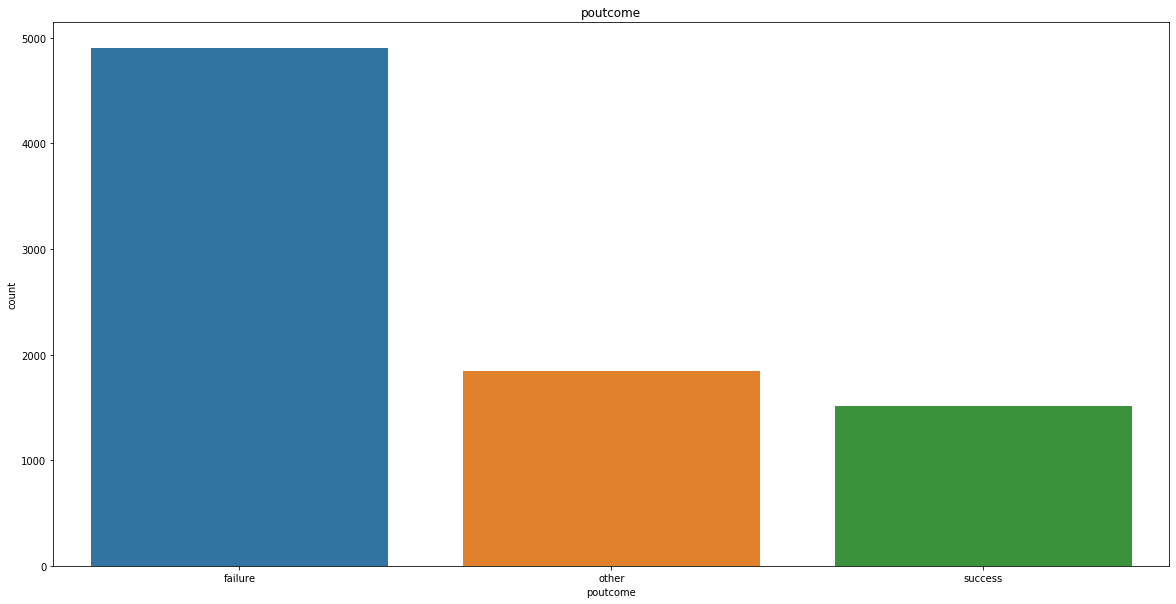

In [225]:
plt.figure(figsize=(20,10))
plt.title('poutcome')
sns.countplot(df['poutcome'])

# EDA Summary:
## Target Customer:
### 1) Student and Retired: Although in our database, we only have a few number of customers who are students or retired, they have high proposition to subscribe term deposit. It is recommend that marketing team should acquire those new customer by create another campaign.
### 2) On the other hands, Management and Technician with Tertiary Level are also potential for targeting as most of our customer is Management and Management and Technician contributes the most term deposit in our bank.
### 3) Single Customer is also another potential group then thosed married.
### 4) Customer with single banking service seems to have higher chance to subscribe the term deposit.
## Resource Allocation:
### 1) We can see that most contact are made on May, Jul, Aug and Nov, however, actaully the most subscriptions occur on Mar, Sep, Oct, Dec. Marketing team should reallocate their resource and ask call centre to contact the customer on Mar, Sep, Oct, Dec.
### 2) Previous Campaign Contact is a good indicator to identify the customer will or will not subscribe term deposit. It's state clearly that customer who accept the previous campaign have higher chance to subscribe term deposit. Although we do not know what last campaign is promoted, the product in last campaign may be correlated to this campaign so that the customer who accept last campaign with higher change to subscribe this term deposit.

# Data Cleaning

In [227]:
## Fill Missing Value 

## Fill Missing Job
df.loc[(df.job.isnull()==True) & (df.age<=30),'job']='student'
df.loc[(df.job.isnull()==True) & (df.age>55),'job']='retired'
df.loc[(df.job.isnull()==True) & (df.education=='tertiary'),'job']='management'
df.loc[df.job.isnull()==True,'job']='blue-collar'

## Fill Missing Education 
df.loc[(df.education.isnull()==True) & (df.job=='management'),'education']='tertiary'
df.loc[(df.education.isnull()==True) & (df.job=='entrepreneur'),'education']='tertiary'
df.loc[(df.education.isnull()==True) & (df.job=='self-employed'),'education']='self-tertiary'
df.loc[(df.education.isnull()==True) & (df.age>40) & (df.job=='housemaid'),'education']='primary'
df.loc[(df.education.isnull()==True) & (df.age<=40) & (df.job=='housemaid'),'education']='primary'
df.loc[(df.education.isnull()==True) & (df.age>45) & (df.job=='retired'),'education']='primary'
df.loc[df.education.isnull()==True,'education']='secondary'
                                                       

## Fill Missing contact 
df.loc[(df.contact.isnull()==True) & (df.day==21),'contact']='telephone'
df.loc[(df.contact.isnull()==True) & (df.day==28),'contact']='telephone'
df.loc[df.contact.isnull()==True,'contact']='cellular'

## Fill Missing poutcome
df.loc[(df['poutcome'].isnull()==True) & (df['pdays']>-1) & (df['duration']>=900),'poutcome']='success'
df.loc[(df['poutcome'].isnull()==True) & (df['pdays']>-1),'poutcome']='failure'
df.loc[df.poutcome.isnull()==True,'poutcome']='no contact before'

df.isnull().sum()
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,BankService,Month,Week,Month_Week,Duration,pMonths
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,no contact before,no,5. Housing and Loan,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,no contact before,no,8. No Service,5,1,MAY Week 1,1. 0-5 mins,1. No contact before


# Feature Engineering

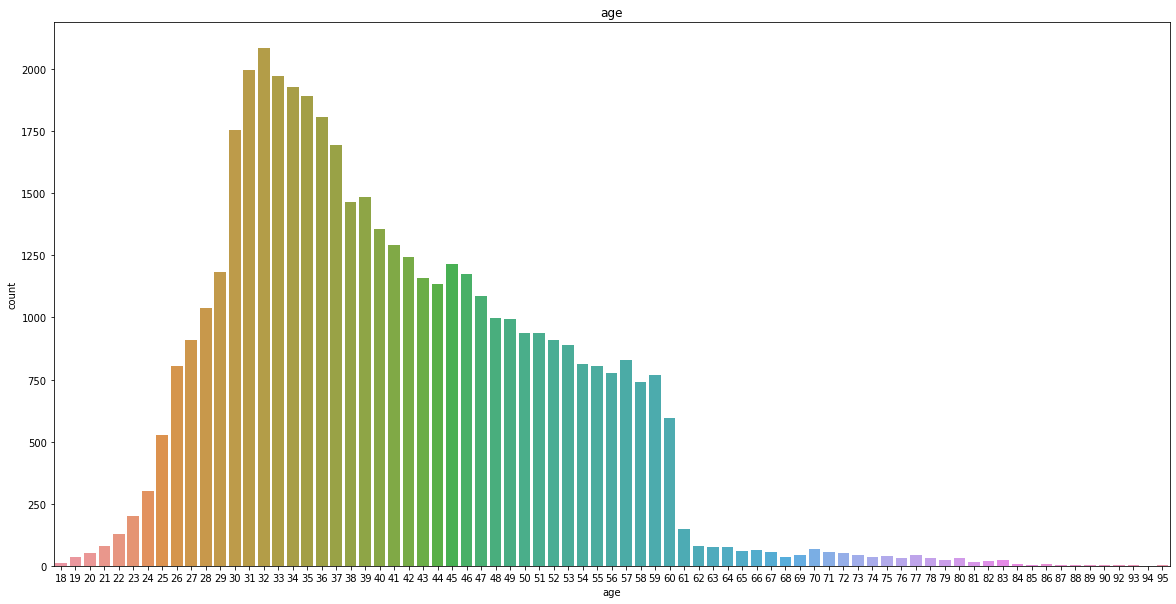

In [253]:
plt.figure(figsize=(20,10))
plt.title('age')
sns.countplot(df['age'])

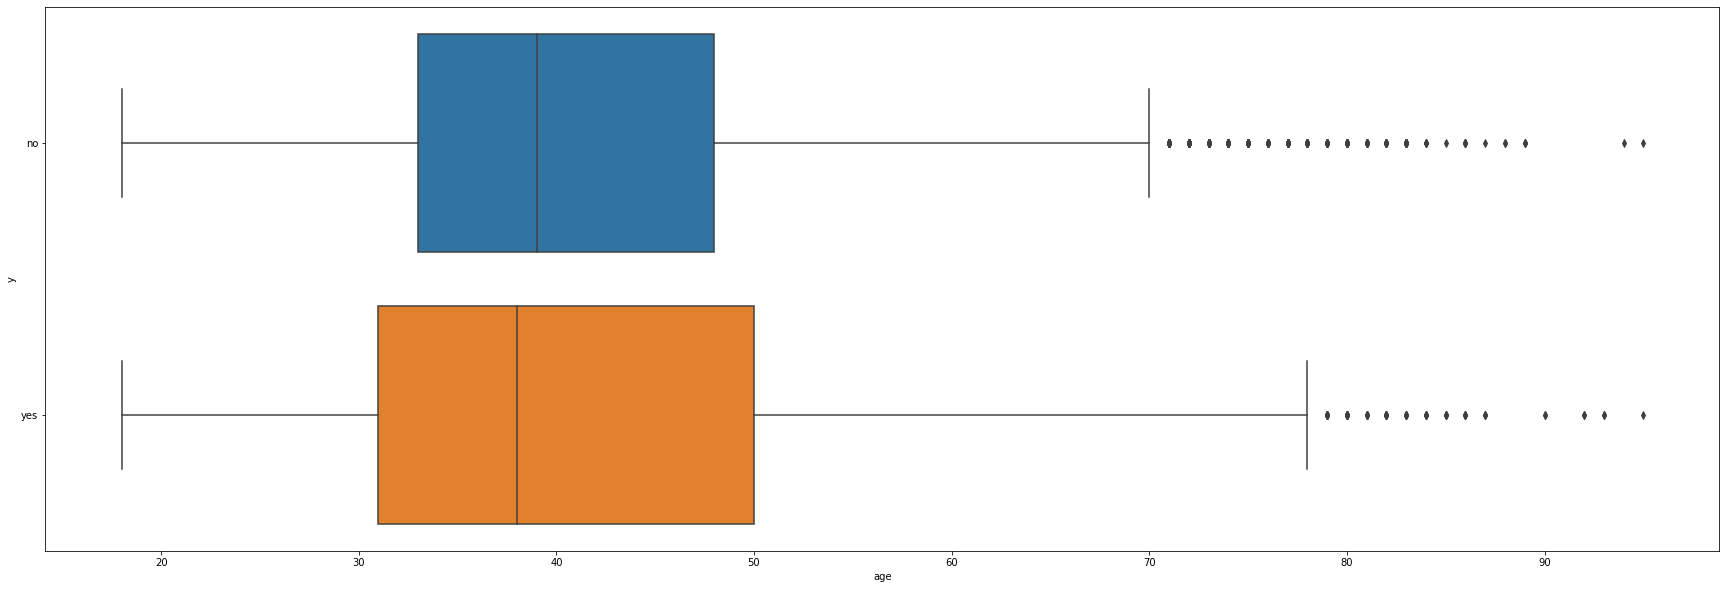

In [228]:
## Check duration and deal with outlier
plt.figure(figsize=(30,10))
sns.boxplot(x='age',y='y',data=df)

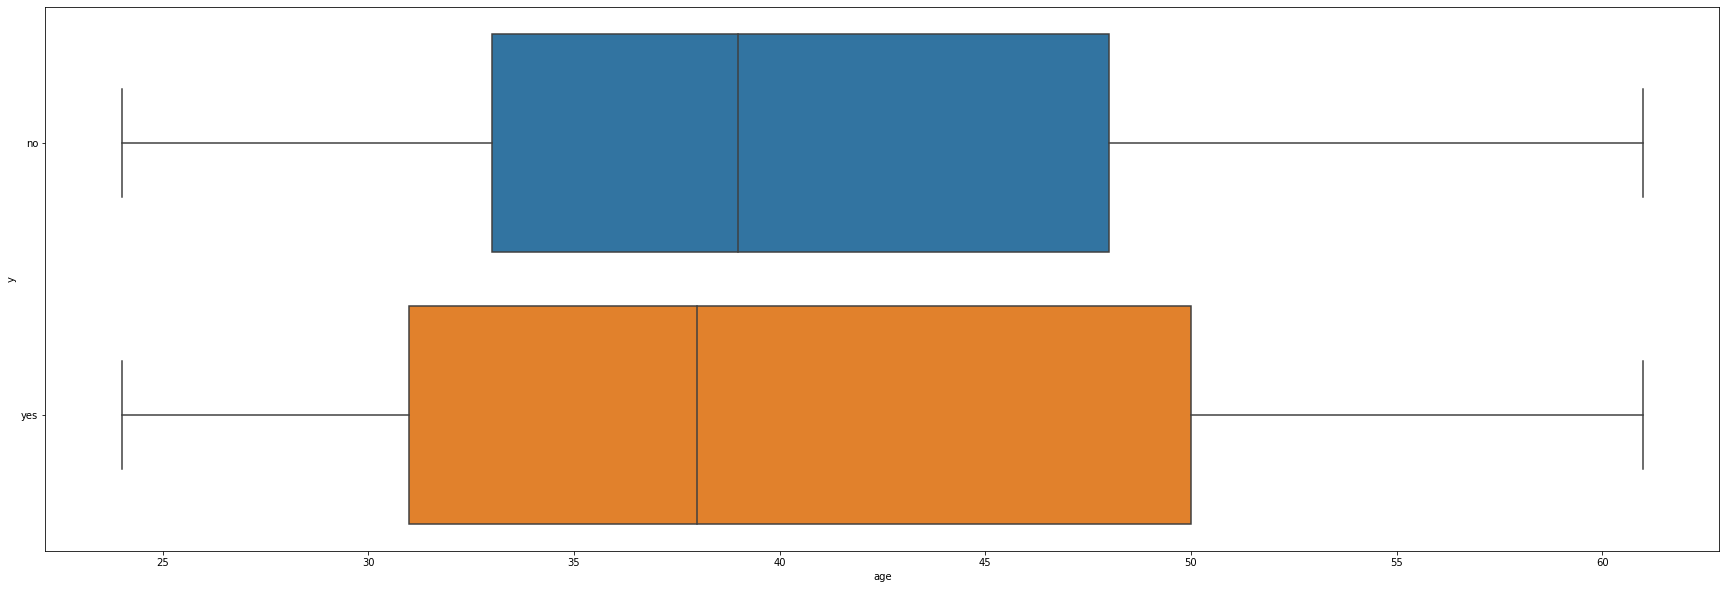

In [229]:
## Make all age Outlier as age<25 and age>60
df.loc[df.age>60,'age']=61
df.loc[df.age<25,'age']=24

plt.figure(figsize=(30,10))
sns.boxplot(x='age',y='y',data=df)


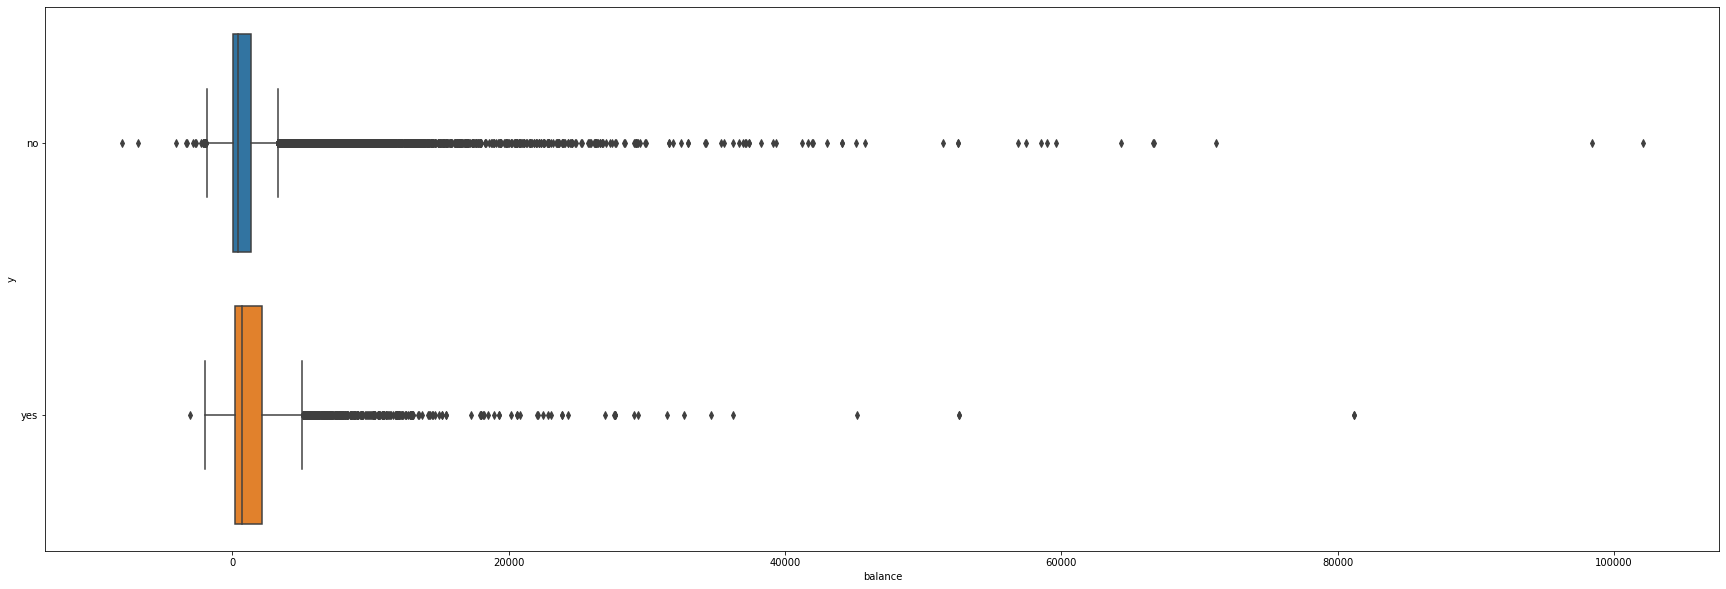

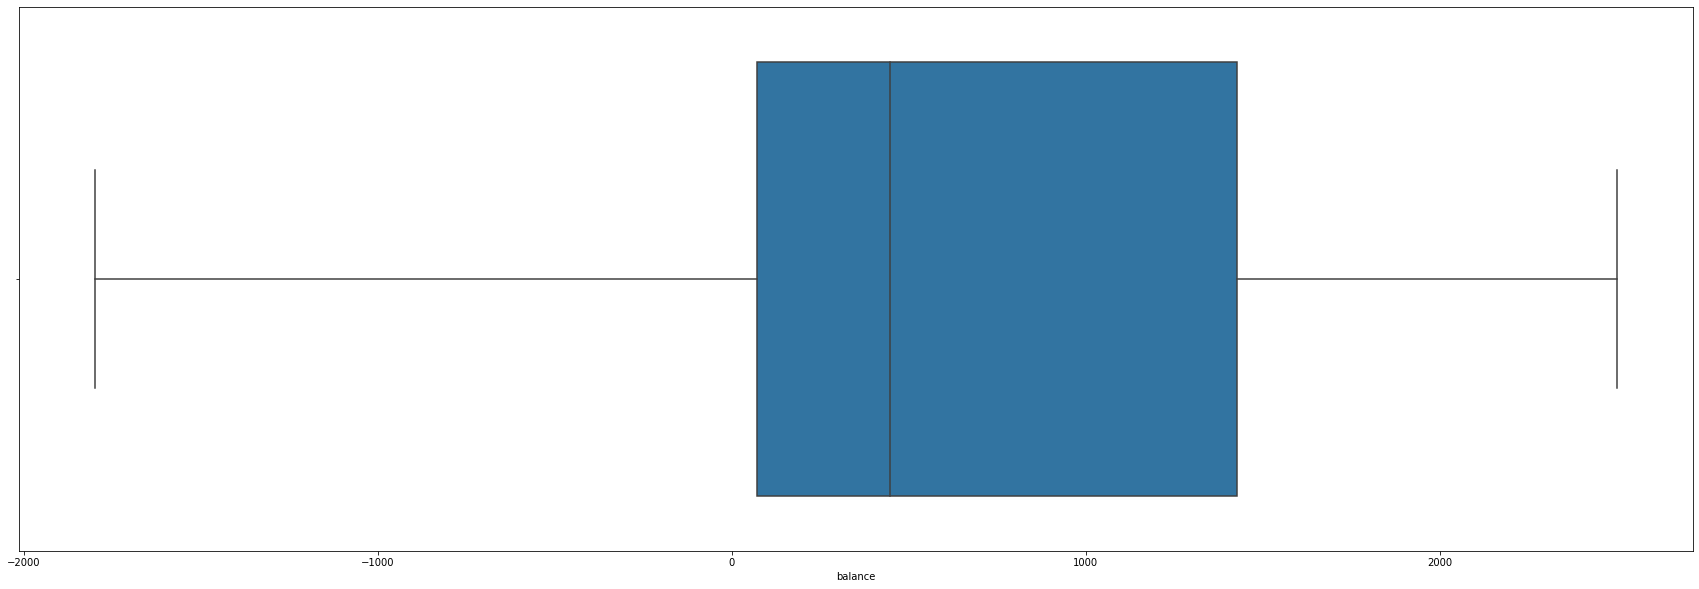

In [232]:
## Check Balance and deal with outlier
plt.figure(figsize=(30,10))
sns.boxplot(x='balance',y='y',data=df)

#Make all Balance Outlier as 2000
df.loc[df.balance>2000,'balance']=2500
df.loc[df.balance<-1800,'balance']=-1800

plt.figure(figsize=(30,10))
sns.boxplot(x='balance',data=df)

In [236]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,BankService,Month,Week,Month_Week,Duration,pMonths
0,58,management,married,tertiary,no,2500,yes,no,cellular,5,may,261,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,no contact before,no,5. Housing and Loan,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,no contact before,no,8. No Service,5,1,MAY Week 1,1. 0-5 mins,1. No contact before


In [269]:
def Previous_group(previous):
    if previous<=5:
        return str(previous)
    else:
        return str('>5')

In [270]:
def Campaign_group(campaign):
    if campaign<=5:
        return str(campaign)
    else:
        return str('>5')

In [271]:
df['Previous_group']=df['previous'].apply(Previous_group)

In [272]:
df['Campaign_group']=df['campaign'].apply(Campaign_group)

In [273]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,BankService,Month,Week,Month_Week,Duration,pMonths,Previous_group,Campaign_group
0,58,management,married,tertiary,no,2500,yes,no,cellular,5,may,261,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before,0,1
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,-1,0,no contact before,no,5. Housing and Loan,5,1,MAY Week 1,1. 0-5 mins,1. No contact before,0,1
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,-1,0,no contact before,no,2. Housing only,5,1,MAY Week 1,1. 0-5 mins,1. No contact before,0,1
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,-1,0,no contact before,no,8. No Service,5,1,MAY Week 1,1. 0-5 mins,1. No contact before,0,1


In [280]:
df_cat=df[['job','marital','education','BankService','contact','month','poutcome','pMonths','Duration','Campaign_group','Previous_group']] #Discreate Dataset
df_int=df[['age','balance']] # Numerical Dataset

In [281]:
#Convert categorical variable into dummy/indicator variables.
df_cat1=pd.get_dummies(df_cat)

In [282]:
df_int.describe()

,age,balance
count,45211.000000,45211.000000
mean,40.735020,821.763929
std,9.970358,953.041485
min,24.000000,-1800.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,61.000000,2500.000000


In [283]:
#Scale numerical data between 0 and 1
scaler = MinMaxScaler()
df_int2=pd.DataFrame(scaler.fit_transform(df_int))
df_int2.columns= ['age','balance']

In [284]:
X0=pd.concat((df_int2,df_cat1),axis=1)
y0=pd.DataFrame(df.loc[:,'y'])
y0['y']=y0['y'].apply(lambda x: 0 if x=='no' else 1)

In [285]:
X0.columns

Index(['age', 'balance', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_self-tertiary',
       'education_tertiary', 'BankService_1. Default only',
       'BankService_2. Housing only', 'BankService_3. Loan only',
       'BankService_4. Default and Housing',
       'BankService_5.  Housing and Loan', 'BankService_6. Default and Loan',
       'BankService_7. Default and Housing and Loan',
       'BankService_8. No Service', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_no contact before', 'poutcome_othe

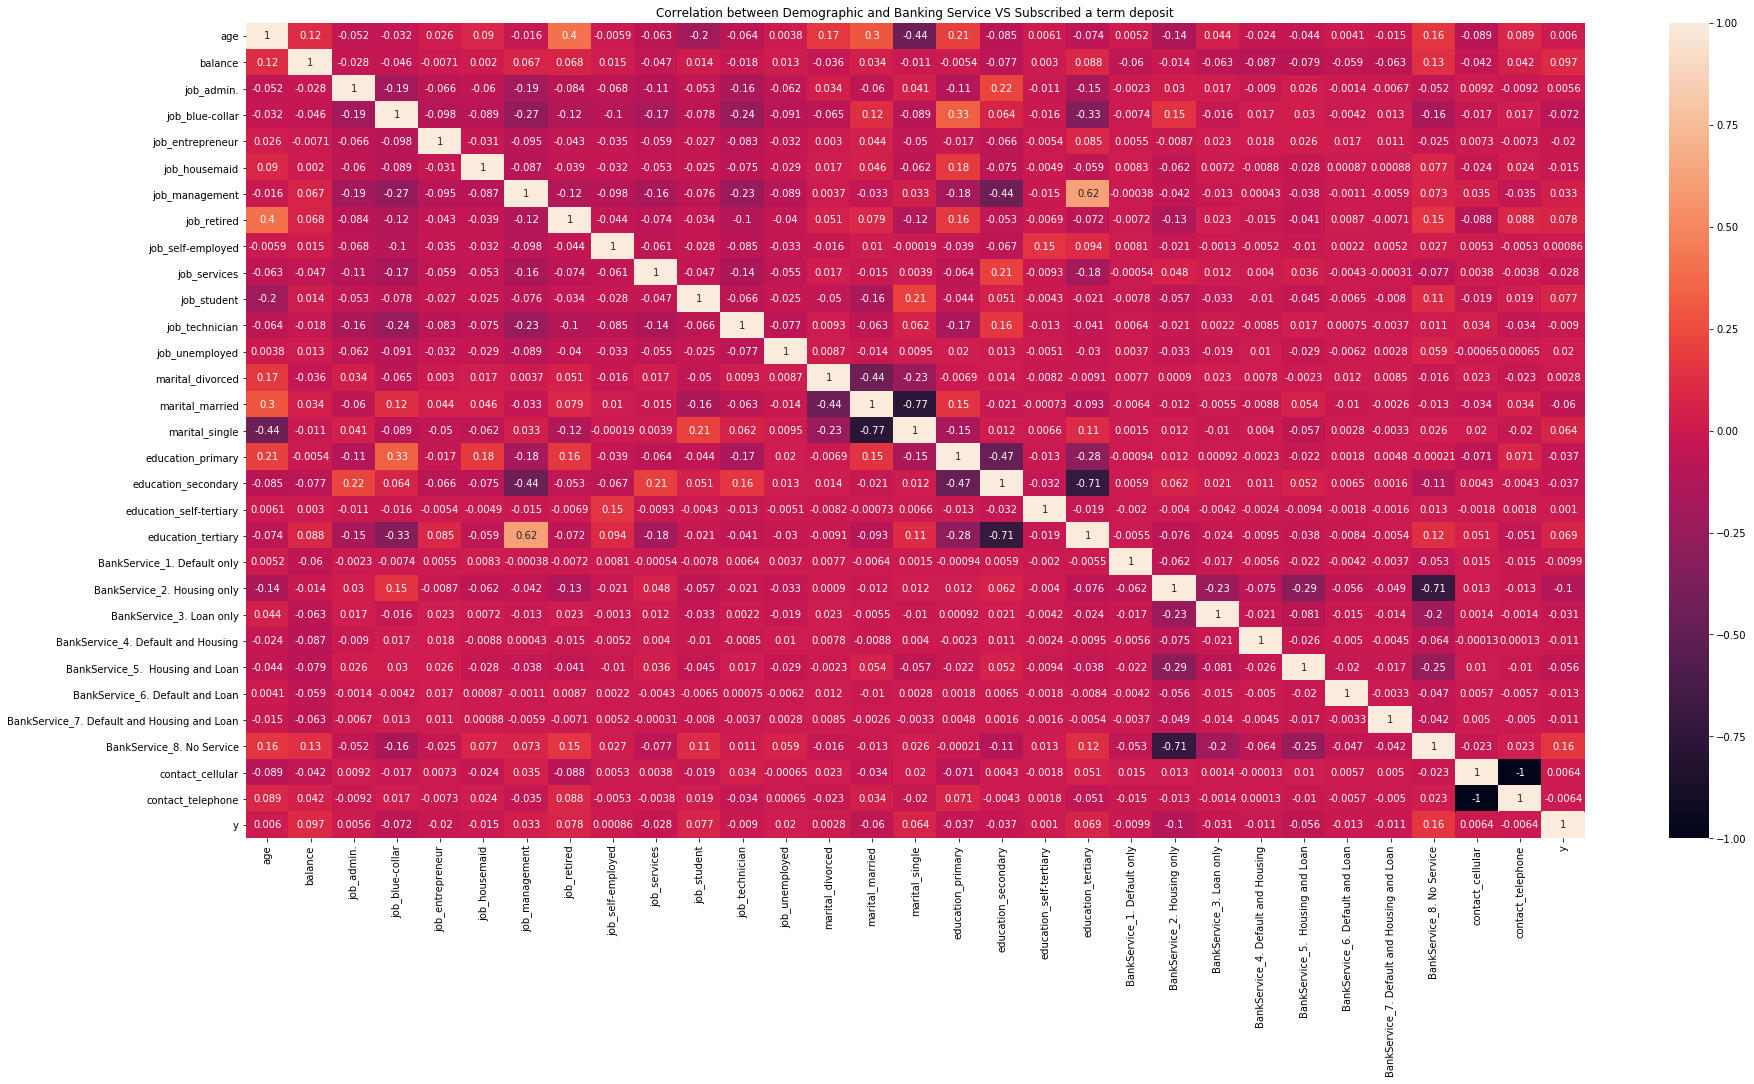

In [286]:
plt.figure(figsize=(30,15))
plt.title('Correlation between Demographic and Banking Service VS Subscribed a term deposit')
Corr=pd.concat((X0[['age', 'balance', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_self-tertiary',
       'education_tertiary', 'BankService_1. Default only',
       'BankService_2. Housing only', 'BankService_3. Loan only',
       'BankService_4. Default and Housing',
       'BankService_5.  Housing and Loan', 'BankService_6. Default and Loan',
       'BankService_7. Default and Housing and Loan',
       'BankService_8. No Service', 'contact_cellular', 'contact_telephone'
                   ]],y0),axis=1)
sns.heatmap(Corr.corr(),vmin=-1,vmax=1,annot=True)

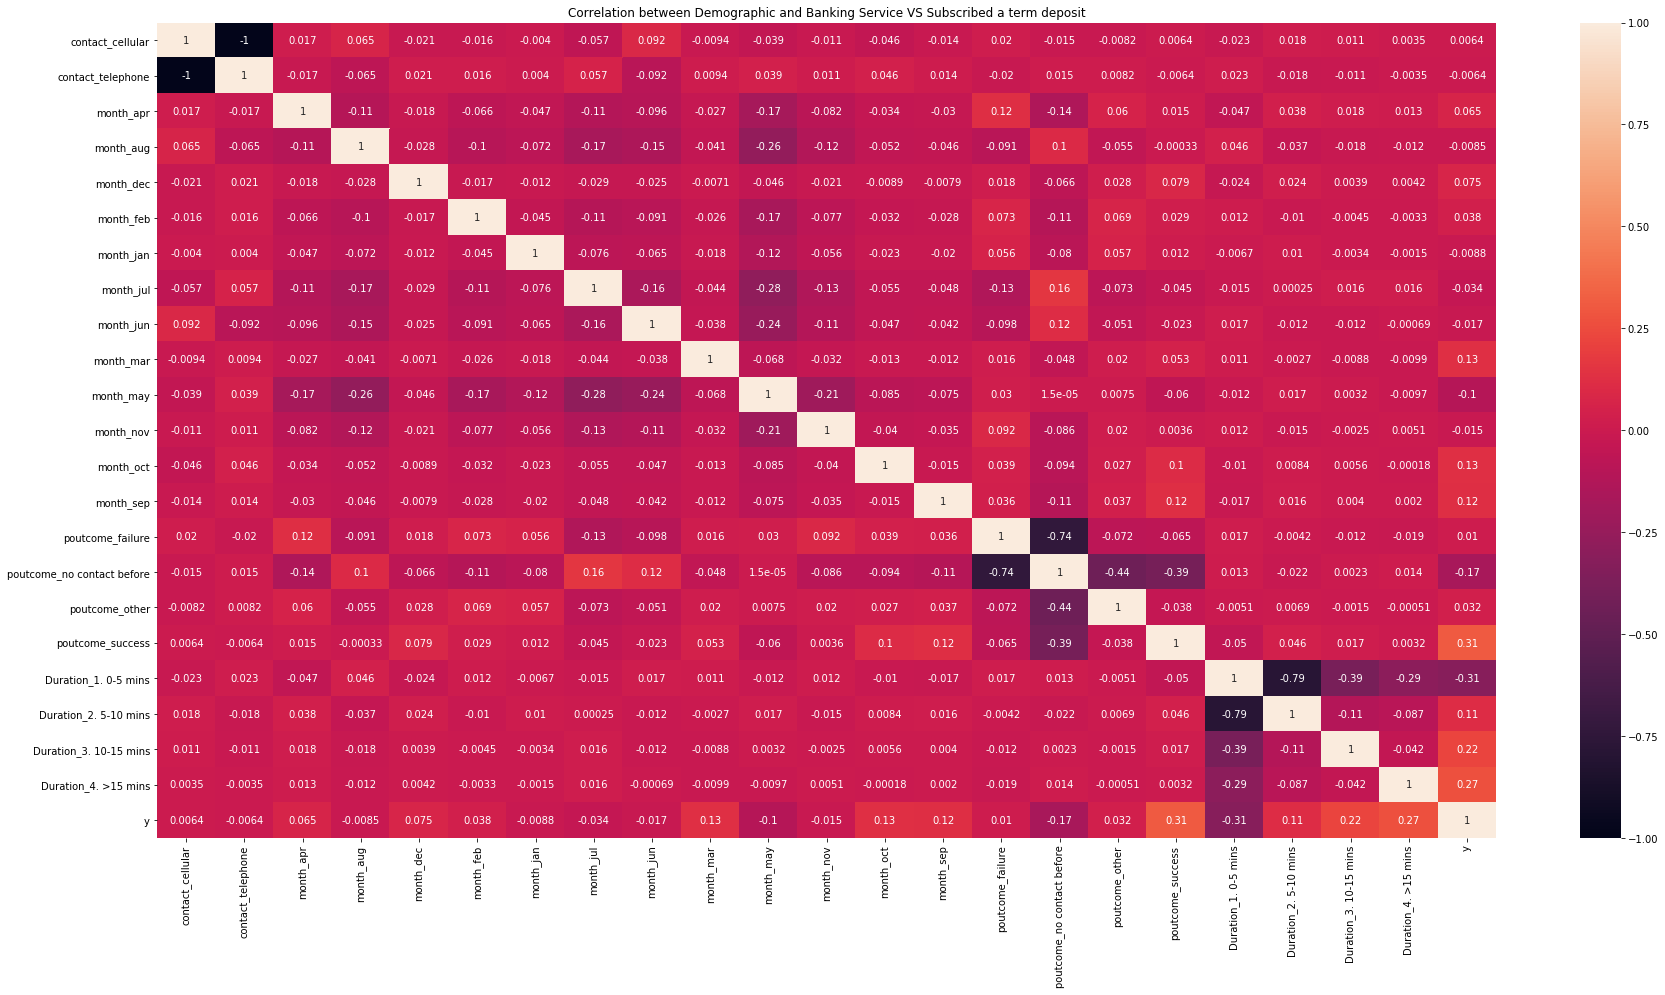

In [287]:
plt.figure(figsize=(30,15))
plt.title('Correlation between Demographic and Banking Service VS Subscribed a term deposit')
Corr=pd.concat((X0[['contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_no contact before', 'poutcome_other', 'poutcome_success',
       'Duration_1. 0-5 mins', 'Duration_2. 5-10 mins',
       'Duration_3. 10-15 mins', 'Duration_4. >15 mins'
                   ]],y0),axis=1)
sns.heatmap(Corr.corr(),vmin=-1,vmax=1,annot=True)

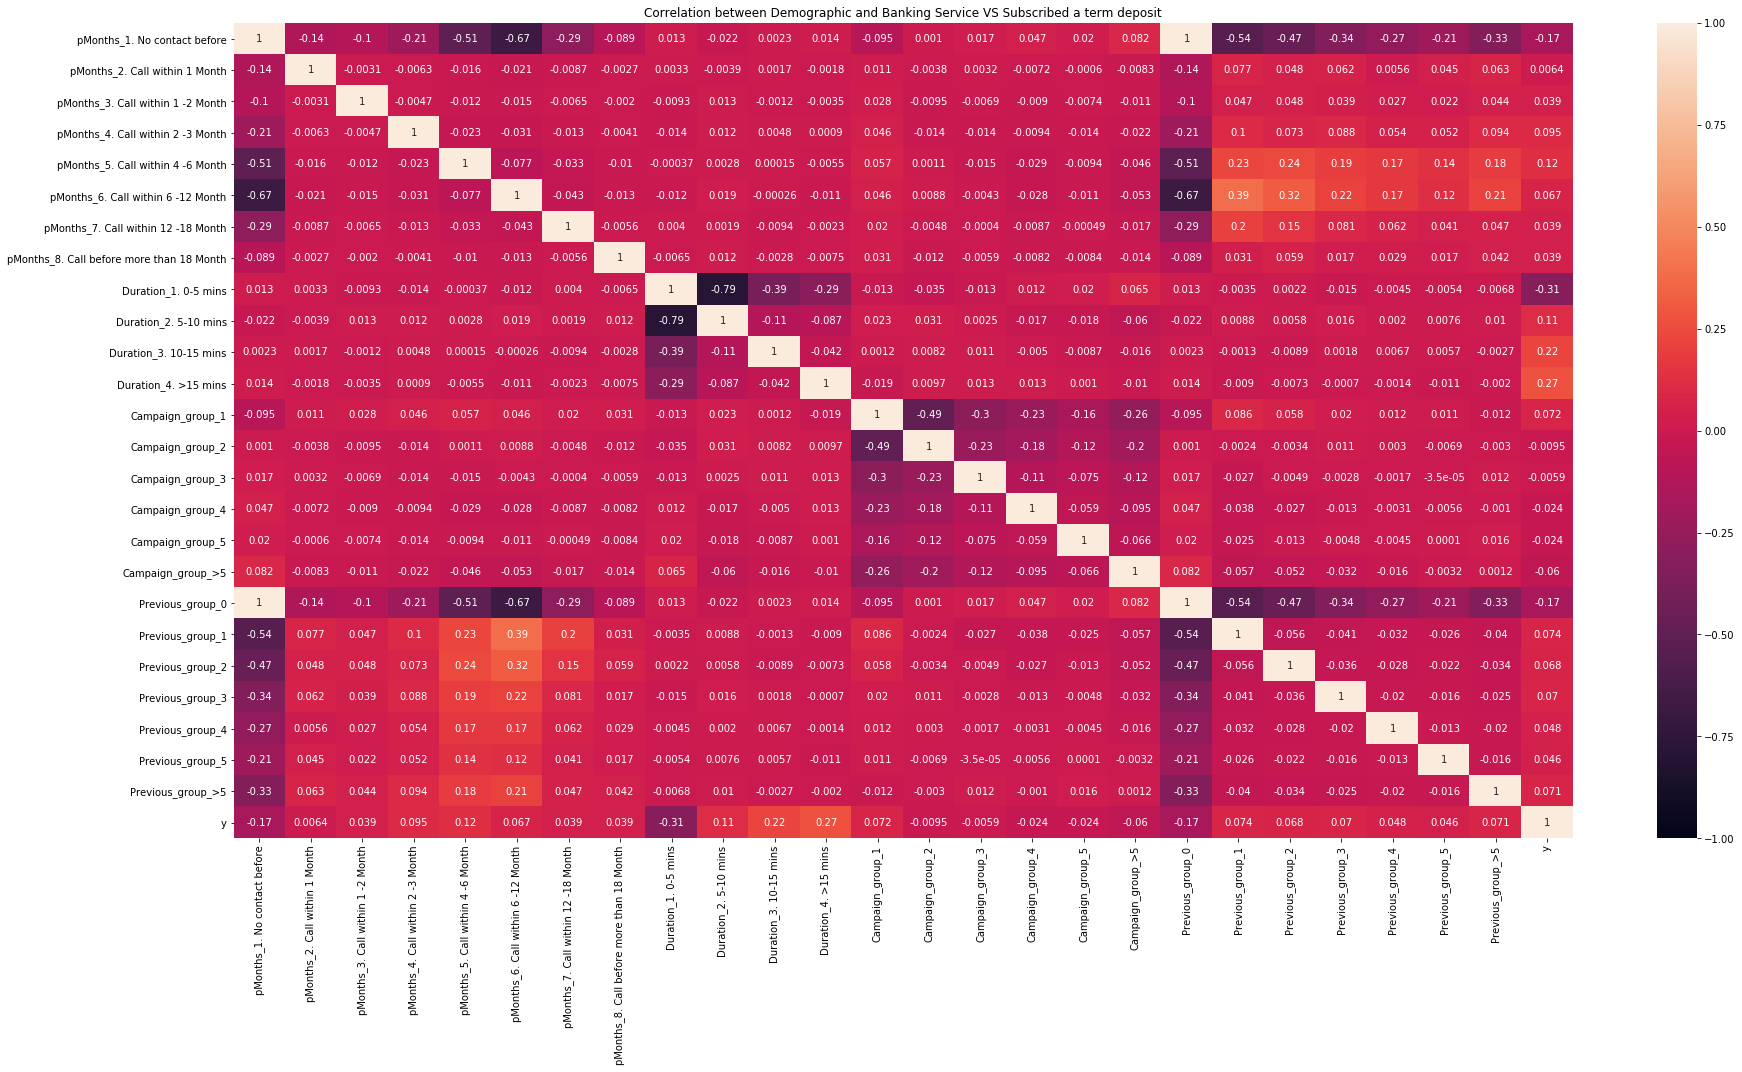

In [288]:
plt.figure(figsize=(30,15))
plt.title('Correlation between Demographic and Banking Service VS Subscribed a term deposit')
Corr=pd.concat((X0[['pMonths_1. No contact before', 'pMonths_2. Call within 1 Month',
       'pMonths_3. Call within 1 -2 Month',
       'pMonths_4. Call within 2 -3 Month',
       'pMonths_5. Call within 4 -6 Month',
       'pMonths_6. Call within 6 -12 Month',
       'pMonths_7. Call within 12 -18 Month',
       'pMonths_8. Call before more than 18 Month', 'Duration_1. 0-5 mins',
       'Duration_2. 5-10 mins', 'Duration_3. 10-15 mins',
       'Duration_4. >15 mins', 'Campaign_group_1', 'Campaign_group_2',
       'Campaign_group_3', 'Campaign_group_4', 'Campaign_group_5',
       'Campaign_group_>5', 'Previous_group_0', 'Previous_group_1',
       'Previous_group_2', 'Previous_group_3', 'Previous_group_4',
       'Previous_group_5', 'Previous_group_>5'
                   ]],y0),axis=1)
sns.heatmap(Corr.corr(),vmin=-1,vmax=1,annot=True)

#### Here, we can see that Duration is positive relation to Term Deposit Subscription. 

# Data Augmentation
### As the datasets is imbalance, we need to oversample the minority class. In this study I use SMOTE (Synthetic Minority Oversampling Technique) to duplicate records in minority class, so, new records can be synthesized from the existing records.

In [289]:
# Oversample data due to imbalance data
from imblearn.over_sampling import SMOTE
smk = SMOTE()
X,y=smk.fit_sample(X0,y0)

# Train Model

In [381]:
from sklearn.model_selection import GridSearchCV

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [383]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(63875, 71) (63875, 1) (15969, 71) (15969, 1)


In [384]:
##Prepare list to store Score
Accuracy_Score=[]
Recall_Score=[]
Precision_Score=[]
F1_Score=[]

### Logistic Regression

In [385]:
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(random_state=42,max_iter=900).fit(X_train, y_train.values.ravel())
y_pred=clf1.predict(X_test)
print(clf1.score(X_test,y_test),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred) )

Accuracy_Score.append(accuracy_score(y_test, y_pred))
Recall_Score.append(recall_score(y_test, y_pred))
Precision_Score.append(precision_score(y_test, y_pred))
F1_Score.append(f1_score(y_test, y_pred))

y_pred1=y_pred

0.9187175151856722 0.8936856469420668 0.9423152387181164 0.9173564242964471


### Support Vector Classifer SVC

In [386]:
from sklearn.svm import SVC
clf2 = SVC(random_state=42,C=0.01).fit(X_train, y_train.values.ravel())
y_pred=clf2.predict(X_test)
print(clf2.score(X_test,y_test),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred) )

Accuracy_Score.append(accuracy_score(y_test, y_pred))
Recall_Score.append(recall_score(y_test, y_pred))
Precision_Score.append(precision_score(y_test, y_pred))
F1_Score.append(f1_score(y_test, y_pred))

y_pred2=y_pred

0.8742563717202079 0.8784269941694579 0.8732272783327167 0.8758194186765615


### KNN

In [387]:
from sklearn.neighbors import KNeighborsClassifier
clf3 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train.values.ravel())
y_pred=clf3.predict(X_test)
print(clf3.score(X_test,y_test),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred) )

Accuracy_Score.append(accuracy_score(y_test, y_pred))
Recall_Score.append(recall_score(y_test, y_pred))
Precision_Score.append(precision_score(y_test, y_pred))
F1_Score.append(f1_score(y_test, y_pred))

y_pred3=y_pred

0.8929801490387625 0.9650167473018236 0.8449923962633066 0.9010250767359704


### Random Forest

In [388]:
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(random_state=42).fit(X_train, y_train.values.ravel())
y_pred=clf4.predict(X_test)
print(clf4.score(X_test,y_test),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred) )

Accuracy_Score.append(accuracy_score(y_test, y_pred))
Recall_Score.append(recall_score(y_test, y_pred))
Precision_Score.append(precision_score(y_test, y_pred))
F1_Score.append(f1_score(y_test, y_pred))

y_pred4=y_pred

0.9329951781576805 0.9569532316089815 0.9143060329501007 0.9351436537762152


### XGBoosing

In [389]:
import xgboost as xgb
dtrain = xgb.DMatrix(data = X_train, label = y_train) 
dtest = xgb.DMatrix(data = X_test, label = y_test) 
# specify parameters via map
param = {'max_depth':11, 'eta':0.3, 'objective':'binary:hinge' }
num_round = 110
clf5 = xgb.train(param, dtrain, num_round)
# make prediction
y_pred = clf5.predict(dtest)
print(accuracy_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred) )

Accuracy_Score.append(accuracy_score(y_test, y_pred))
Recall_Score.append(recall_score(y_test, y_pred))
Precision_Score.append(precision_score(y_test, y_pred))
F1_Score.append(f1_score(y_test, y_pred))

y_pred5=y_pred

0.9318053729100132 0.933258900880784 0.931756254644538 0.9325069724202045


# Model Evaluation

In [390]:
ind_name=['Accuracy_Score','Recall_Score','Precision_Score','F1_Score']
summary=pd.DataFrame(np.vstack((Accuracy_Score,Recall_Score,Precision_Score,F1_Score)),
                      columns=['Logistic Regression',
                               'SVC',
                               'KNN',
                               'Random Forest',
                               'XGB'],index=ind_name)
summary

,Logistic Regression,SVC,KNN,Random Forest,XGB
Accuracy_Score,0.918718,0.874256,0.892980,0.932995,0.931805
Recall_Score,0.893686,0.878427,0.965017,0.956953,0.933259
Precision_Score,0.942315,0.873227,0.844992,0.914306,0.931756
F1_Score,0.917356,0.875819,0.901025,0.935144,0.932507


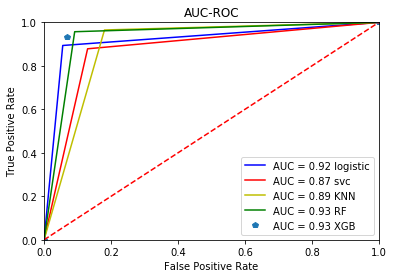

In [392]:
import sklearn.metrics as metrics

fpr11, tpr11, threshold = metrics.roc_curve(y_test, y_pred1)
roc_auc11 = metrics.auc(fpr11, tpr11)
fpr12, tpr12, threshold = metrics.roc_curve(y_test, y_pred2)
roc_auc12 = metrics.auc(fpr12, tpr12)
fpr13, tpr13, threshold = metrics.roc_curve(y_test, y_pred3)
roc_auc13 = metrics.auc(fpr13, tpr13)
fpr14, tpr14, threshold = metrics.roc_curve(y_test, y_pred4)
roc_auc14 = metrics.auc(fpr14, tpr14)
fpr15, tpr15, threshold = metrics.roc_curve(y_test, y_pred5)
roc_auc15 = metrics.auc(fpr15, tpr15)

# method I: plt
import matplotlib.pyplot as plt
plt.title('AUC-ROC')
plt.plot(fpr11, tpr11, 'b', label = 'AUC = %0.2f logistic' % roc_auc11)
plt.plot(fpr12, tpr12, 'r', label = 'AUC = %0.2f svc' % roc_auc12)
plt.plot(fpr13, tpr13, 'y', label = 'AUC = %0.2f KNN' % roc_auc13)
plt.plot(fpr14, tpr14, 'g', label = 'AUC = %0.2f RF' % roc_auc14)
plt.plot(fpr15, tpr15, 'p', label = 'AUC = %0.2f XGB' % roc_auc15)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model Selection:
### From the above result, the Accuracy Score of Random Forest and XGB are similar and Random Forest is the highest, while SVC is the lowest.
### In our business question, we want to provide a list to marketing that should have higher True Positive and lower False Positive.
### From the AUC-ROC, we should choose Random Forest as our Training Model.

# Apply the model in another test file

In [401]:
test_data=pd.read_csv('test.csv',delimiter=';')
test_data.shape

(4521, 17)

In [397]:
## Fill Missing Value 

## Fill Missing Job
test_data.loc[(test_data.job.isnull()==True) & (test_data.age<=30),'job']='student'
test_data.loc[(test_data.job.isnull()==True) & (test_data.age>55),'job']='retired'
test_data.loc[(test_data.job.isnull()==True) & (test_data.education=='tertiary'),'job']='management'
test_data.loc[test_data.job.isnull()==True,'job']='blue-collar'

## Fill Missing Education 
test_data.loc[(test_data.education.isnull()==True) & (test_data.job=='management'),'education']='tertiary'
test_data.loc[(test_data.education.isnull()==True) & (test_data.job=='entrepreneur'),'education']='tertiary'
test_data.loc[(test_data.education.isnull()==True) & (test_data.job=='self-employed'),'education']='self-tertiary'
test_data.loc[(test_data.education.isnull()==True) & (test_data.age>40) & (test_data.job=='housemaid'),'education']='primary'
test_data.loc[(test_data.education.isnull()==True) & (test_data.age<=40) & (test_data.job=='housemaid'),'education']='primary'
test_data.loc[(test_data.education.isnull()==True) & (test_data.age>45) & (test_data.job=='retired'),'education']='primary'
test_data.loc[test_data.education.isnull()==True,'education']='secondary'
                                                       

## Fill Missing contact 
test_data.loc[(test_data.contact.isnull()==True) & (test_data.day==21),'contact']='telephone'
test_data.loc[(test_data.contact.isnull()==True) & (test_data.day==28),'contact']='telephone'
test_data.loc[test_data.contact.isnull()==True,'contact']='cellular'

## Fill Missing poutcome
test_data.loc[(test_data['poutcome'].isnull()==True) & (test_data['pdays']>-1) & (test_data['duration']>=900),'poutcome']='success'
test_data.loc[(test_data['poutcome'].isnull()==True) & (test_data['pdays']>-1),'poutcome']='failure'
test_data.loc[test_data.poutcome.isnull()==True,'poutcome']='no contact before'

test_data['pMonths']=test_data['pdays'].apply(lastcall)
test_data['Duration']=test_data['duration'].apply(duration_group)
test_data['BankService']=test_data[['default','housing','loan']].apply(lambda x:BankingService(*x),axis=1)
test_data['Previous_group']=test_data['previous'].apply(Previous_group)
test_data['Campaign_group']=test_data['campaign'].apply(Campaign_group)

In [398]:
#Convert categorical variable into dummy/indicator variables.
test_cat1=pd.get_dummies(test_cat)

#Scale numerical data between 0 and 1
#scaler = MinMaxScaler()
test_int2=pd.DataFrame(scaler.fit_transform(test_int))
test_int2.columns= ['age','balance']

test_X0=pd.concat((test_int2,test_cat1),axis=1)
test_y0=pd.DataFrame(df.loc[:,'y'])
test_y0['y']=test_y0['y'].apply(lambda x: 0 if x=='no' else 1)

In [399]:
y_pred=clf4.predict(test_X0)
print(clf4.score(test_X0,test_y0),recall_score(test_y0, y_pred),precision_score(test_y0, y_pred),f1_score(test_y0, y_pred) )

#dtest_data = xgb.DMatrix(data = test_X0, label = test_y0) 
#y_pred = clf5.predict(dtest_data)
#print(accuracy_score(test_y0,y_pred),recall_score(test_y0, y_pred),precision_score(test_y0, y_pred),f1_score(test_y0, y_pred) )

0.9781690296609232 0.9536774437511817 0.8717594192879364 0.9108803611738149


#### By using another Testing Dataset, we can see that there are 4521 records.
#### The Accuracy Rate is so high around 97.8%